<table width="100%">
  <tr>
    <td>
      <h1 style="text-align: left; font-size:300%;">Data Preparation Pipeline</h1>
      <h2 style="text-align: left; font-size:200%;">Project ID: 20</h2>
      <h3 style="text-align: left; font-size:150%;">Dataset 9: Comune di Milano Esercizi di vicinato in sede fissa</h3>
      <table align="left">
        <tr>
          <td style="text-align: left; font-size: 120%;">Sara Resta</td>
          <td style="text-align: left; font-size: 120%;">10667600</td>
          <td style="text-align: left; font-size: 120%;"><a href="mailto:sara.resta@mail.polimi.it">sara.resta@mail.polimi.it</a></td>
        </tr>
        <tr>
          <td style="text-align: left; font-size: 120%;">Francesco Scroccarello</td>
          <td style="text-align: left; font-size: 120%;">10723028</td>
          <td style="text-align: left; font-size: 120%;"><a href="mailto:francesco.scroccarello@mail.polimi.it">francesco.scroccarello@mail.polimi.it</a></td>
        </tr>
      </table>
    </td>
    <td width="20%">
      <div style="text-align: right">
          <br>
        <b style="font-size: 150%;">Data and Information quality course</b><br>
        <b>a.y. 2024-2025</b>
          <br><br>
        prof. Cinzia Cappiello
      </div>
    </td>
  </tr>
</table>


# Contents
1. [Imports and utilities](#1.-Imports-and-utilities)  
2. [Data Profiling and Data Quality assessment](#2.-Data-Profiling-and-Data-Quality-assessment)  
    2.1. [Basic profiling operations](#2.1.-Basic-profiling-operations)  
    2.2. [Single column analysis](#2.2.-Single-column-analysis)  
    &emsp; 2.2.1. [Cardinalities](#2.2.1.-Cardinalities)  
    &emsp; 2.2.2. [Values distributions](#2.2.2.-Values-distributions)  
    2.3. [Dependency Discovery](#2.3.-Dependency-Discovery)
3. [DQ assessment](#3.-DQ-assesment)
4. [Data Wrangling](#4.-Data-Wrangling)  
    4.1. [Settore Merceologico](#4.1.-Settore-Merceologico)  
    4.2. [Insegna](#4.2.-Insegna)  
    4.3. [Ubicazione](#4.3.-Ubicazione)  
    4.4. [Tipo via, Via, Civico, Codice via, Settore Storico Cf Preval](#4.4.-Tipo-via-Via,-Civico,-Codice-via,-Settore-Storico-Cf-Preval)  
    4.5. [Superficie](#4.5.-Superficie)
5. [Inconsistencies](#5.-Inconsistencies)
6. [Missing values handling](#5.-Missing-values-handling)  
    6.1. [Tipo via, Via, Civico, Codice via, ZD](#6.1.-Tipo-via-Via,-Civico,-Codice-via,-ZD)  
    6.2. [Accesso, Isolato, Website, Altre Info](#6.2.-Accesso,-Isolato,-Website,-Altre-Info)  
    6.3. [Superficie](#6.3.-Superficie)  
    6.4. [Settore Merceologico Secondario, Insegna and Settore Storico Cf Preval](#6.4.-Settore-Merceologico-Secondario,-Insegna-and-Settore-Storico-Cf-Preval)  
    6.5. [Settore Merceologico Primario](#6.5.-Settore-Merceologico-Primario)
7. [Outliers handling](#7.-Outliers-handling)

# 1. Imports and utilities
[$\leftarrow$ Back to contents](#Contents)

In [94]:
# Libraries to handle datasets
import json
import pandas as pd
import numpy as np

# Libraries for plots
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# Warnings
import warnings
warnings.filterwarnings("ignore")

# Statistics
from scipy.stats import pearsonr, spearmanr, shapiro

# Profile report
from ydata_profiling import ProfileReport

# ML libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Association rules libraries
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import fpgrowth

In [95]:
# set pandas print to fully visualize data when needed
#pd.set_option("display.max_rows", None)

ZD: sono i municipi di milano come si vede a [questo link](https://it.wikipedia.org/wiki/Municipi_di_Milano). Nel .csv sono riportati come numero intero, che però non rappresenta una variabile numerica ma categorica. Per questo motivo questa colonna viene importata come stringa.

In [96]:
# import of the dataset
df = pd.read_csv("Comune-di-Milano-Esercizi-di-vicinato-in-sede-fissa-dirty.csv", sep=';', encoding='unicode_escape', dtype={'ZD': str})

In [97]:
# show first 10 records just for a visualization
df.head()

Settore Merceologico Insegna  \
0                  NaN     NaN   
1                  NaN     NaN   
2                  NaN     NaN   
3                  NaN     NaN   
4                  NaN     NaN   

                                       Ubicazione Tipo via  \
0                       CSO ITALIA N. 34 (z.d. 1)      CSO   
1                        CSO LODI N. 104 (z.d. 4)      CSO   
2                         CSO LODI N. 26 (z.d. 5)      CSO   
3                     CSO SEMPIONE N. 41 (z.d. 6)      CSO   
4  LGO SCALABRINI GIOVANNI BATTISTA N. 2 (z.d. 6)      LGO   

                            Via Civico Codice via ZD  \
0                        ITALIA     34        526  1   
1                          LODI    104       4068  4   
2                          LODI     26       4068  5   
3                      SEMPIONE     41       7137  8   
4  SCALABRINI GIOVANNI BATTISTA      2       5392  6   

  Settore Storico Cf Preval  Superficie Vendita  Superficie Altri Usi  \
0     speciale panificatori                 0.0                   NaN   
1                       NaN                16.0                   5.0   
2     speciale panificatori                 0.0                   NaN   
3                       NaN               120.0                   NaN   
4                       NaN                 0.0                   NaN   

   Superficie Tabelle Speciali  Superficie Totale  
0                          NaN                0.0  
1                          NaN               21.0  
2                          NaN                0.0  
3                          NaN              120.0  
4                          NaN                0.0

# 2. Data Profiling
[$\leftarrow$ Back to contents](#Contents)

## 2.1. Basic profiling operations

In [98]:
n_rows = df.shape[0]
n_cols = df.shape[1]
print(f"Num of rows: {n_rows}\nNum of columns: {n_cols}")

Num of rows: 24136
Num of columns: 13


In [99]:
print("COLUMNS OF THE DATASET:")
for col in df.columns:
    print(f"{col}")

COLUMNS OF THE DATASET:
Settore Merceologico
Insegna
Ubicazione
Tipo via
Via
Civico
Codice via
ZD
Settore Storico Cf Preval
Superficie Vendita
Superficie Altri Usi
Superficie Tabelle Speciali
Superficie Totale


In [100]:
# show for each column the type of its elements
df.dtypes

Settore Merceologico            object
Insegna                         object
Ubicazione                      object
Tipo via                        object
Via                             object
Civico                          object
Codice via                      object
ZD                              object
Settore Storico Cf Preval       object
Superficie Vendita             float64
Superficie Altri Usi           float64
Superficie Tabelle Speciali    float64
Superficie Totale              float64
dtype: object

In [101]:
# separate numerical variables from categorical
num = df[df.select_dtypes(include=['float64']).columns] 
cat = df[df.select_dtypes(include=['object']).columns]

## 2.2. Single column analysis
[$\leftarrow$ Back to contents](#Contents)

### 2.2.1. Cardinalities

For each column, we compute:

- Missing: number of missing values
- Actual: count of the number of records with an actual value (*i.e.,* not-null).
- Cardinality: count of the number of distinct actual values.
- Uniqueness: percentage calculated as Cardinality divided by the total number of records.
- Distinctness: percentage calculated as Cardinality divided by Actual.
- Constancy: "how frequent" is the most frequent value (can help spot standard)

In [102]:
# perform single column analysis for each column
sc_analysis = pd.DataFrame(columns=df.columns,index=['Missing','Actual','Cardinality'])

for col in df.columns:
    cardinality = df[col].nunique() # number of unique values
    actual = df[col].notnull().sum() # number of not null values
    nnull = df[col].isnull().sum() # number of null values

    sc_analysis.loc['Missing', col] = nnull
    sc_analysis.loc['Cardinality', col] = cardinality
    sc_analysis.loc['Actual', col] = actual
    
sc_analysis


Settore Merceologico Insegna Ubicazione Tipo via    Via Civico  \
Missing                      105   17147          1        2      1    650   
Actual                     24031    6989      24135    24134  24135  23486   
Cardinality                   56    5583      16907       20   2331    386   

            Codice via     ZD Settore Storico Cf Preval Superficie Vendita  \
Missing              2      2                        33                 30   
Actual           24134  24134                     24103              24106   
Cardinality       2348     10                      2228                250   

            Superficie Altri Usi Superficie Tabelle Speciali Superficie Totale  
Missing                    15098                       23009                36  
Actual                      9038                        1127             24100  
Cardinality                  438                         117               642

### 2.2.2. Values distributions
[$\leftarrow$ Back to contents](#Contents)

In [103]:
# extract basic statistics for the numerical variables
stats = num.describe()
stats

Superficie Vendita  Superficie Altri Usi  Superficie Tabelle Speciali  \
count        24106.000000           9038.000000                  1127.000000   
mean            56.762715             67.852069                    37.138421   
std             49.281531            280.890686                    29.824418   
min              0.000000              0.000000                     1.000000   
25%             25.000000             10.000000                    13.000000   
50%             40.000000             21.000000                    30.000000   
75%             70.000000             50.000000                    52.500000   
max            250.000000           9056.000000                   230.000000   

       Superficie Totale  
count       24100.000000  
mean           98.350747  
std           266.692535  
min             0.000000  
25%            35.000000  
50%            55.000000  
75%           100.000000  
max         11942.000000

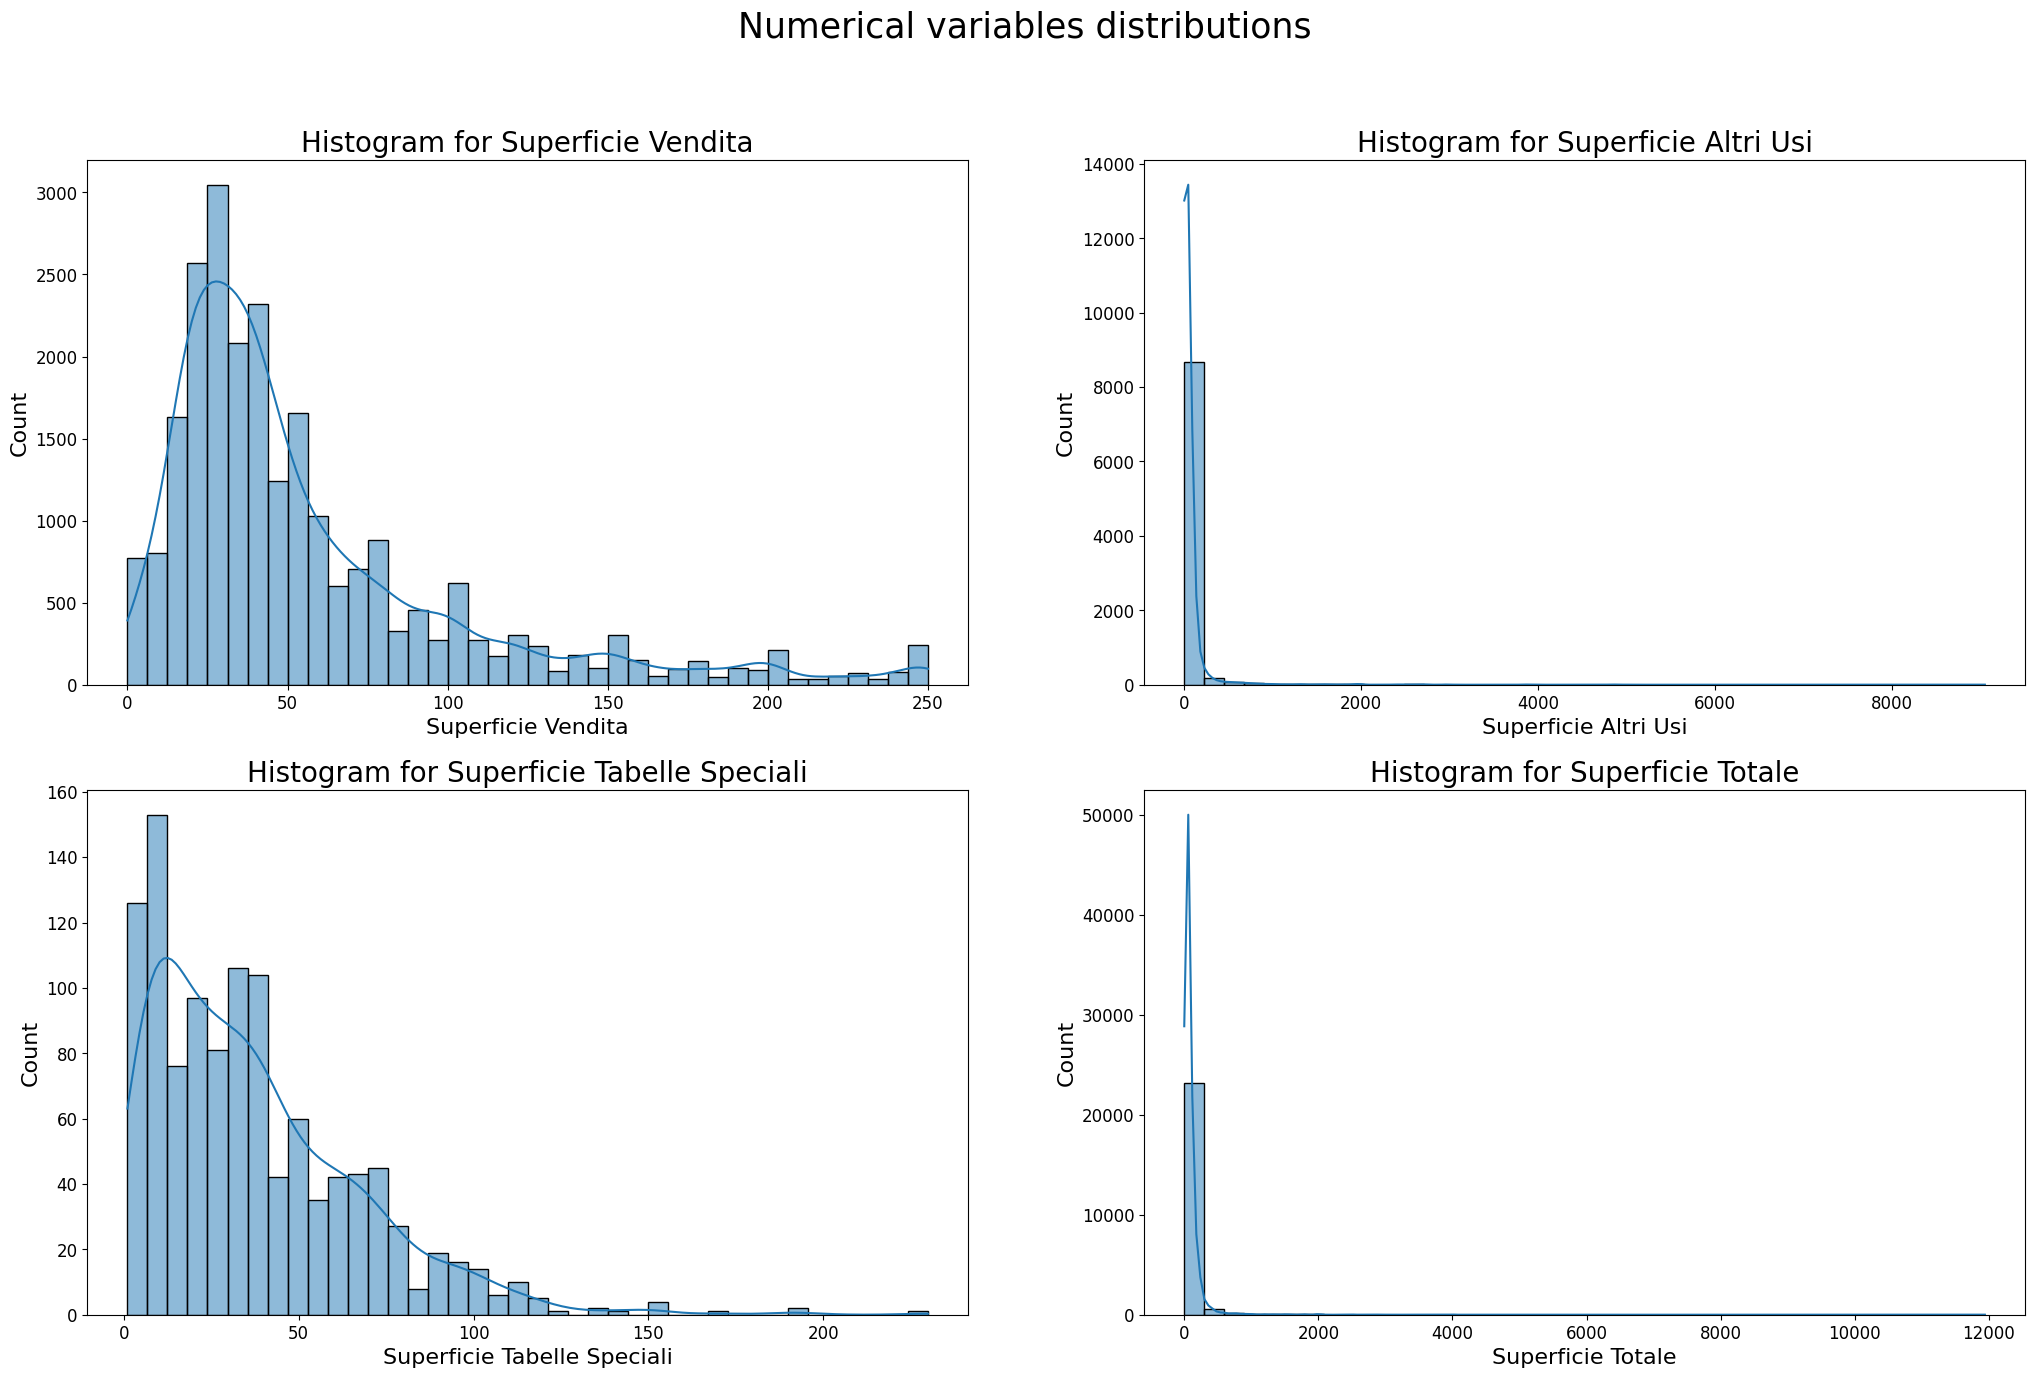

In [104]:
# Plot values distributions
plt.figure(figsize=(25,15))
plt.suptitle("Numerical variables distributions", fontsize=25)
for i, col in enumerate(num):
    plt.subplot(2, 2, i + 1)
    sns.histplot(df[col], kde=True, bins=40)
    plt.title(f"Histogram for {col}",fontsize=20)
    plt.xticks(fontsize=12)  
    plt.yticks(fontsize=12)
    plt.xlabel(f"{col}", fontsize=16)
    plt.ylabel("Count", fontsize=16)

Non mi sembra che ci siano risultati molto interessanti, secondo me questo plot sotto lo possiamo togliere

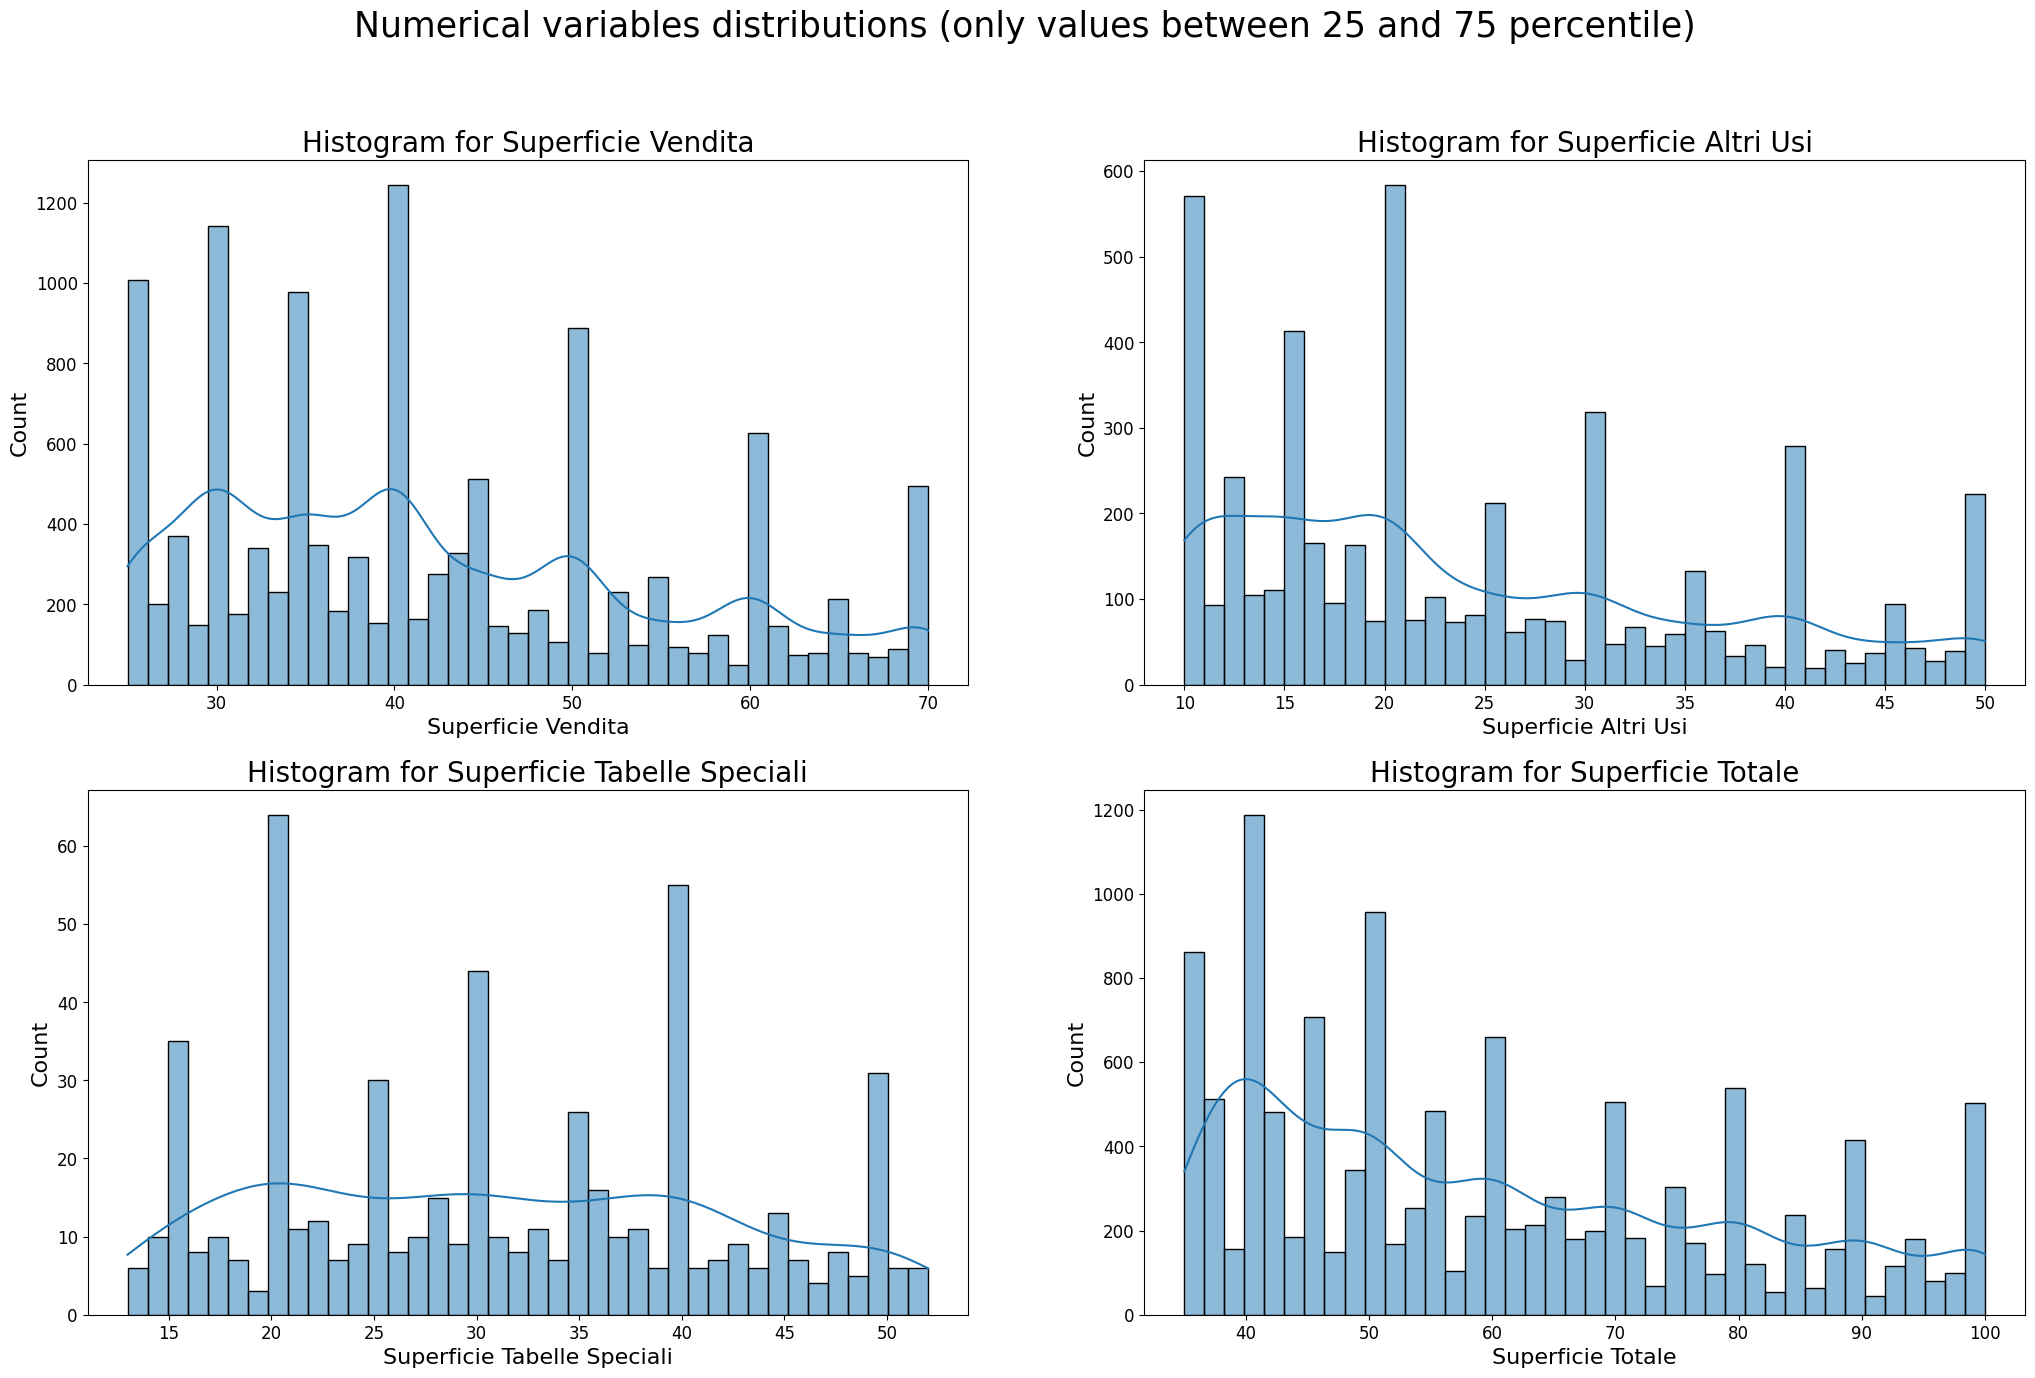

In [105]:
# Plot values distributions: only between 25 and 75 percentile
plt.figure(figsize=(25,15))
plt.suptitle("Numerical variables distributions (only values between 25 and 75 percentile)", fontsize=25)
for i, col in enumerate(num):
    perc_25_threshold = stats.loc['25%',col]
    perc_75_threshold = stats.loc['75%',col]
    plt.subplot(2, 2, i + 1)
    val_subset = df[(df[col] >= perc_25_threshold) & (df[col] <= perc_75_threshold)][col]
    sns.histplot(val_subset, kde=True, bins=40)
    plt.title(f"Histogram for {col}",fontsize=20)
    plt.xticks(fontsize=12)  
    plt.yticks(fontsize=12)
    plt.xlabel(f"{col}", fontsize=16)
    plt.ylabel("Count", fontsize=16)

Per le categoriche ho pensato a dei barplot, giusto per vedere se visivamente ci siano delle categorie molto sbilanciate. Qui vediamo che:
* abbiamo palesemente un outlier in 60
* la maggior parte dei negozi sta nella zona uno (quella centrale)

In [106]:
df['Settore Merceologico'].value_counts().shape

(56,)

Text(0, 0.5, 'ZD')

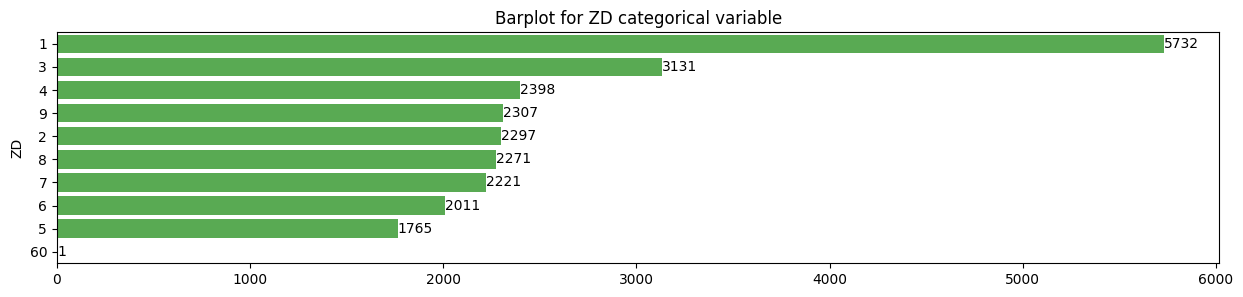

In [107]:
col ='ZD'
plt.figure(figsize=(15,3))
ax = sns.barplot(x=df[col].value_counts().values, y=df[col].value_counts().index,
             errorbar=None, order=df[col].value_counts().index, color='#4CB944')
ax.bar_label(ax.containers[0], fontsize=10)
plt.title(f"Barplot for {col} categorical variable")
plt.ylabel(f"{col}")

Text(0, 0.5, 'Settore Merceologico')

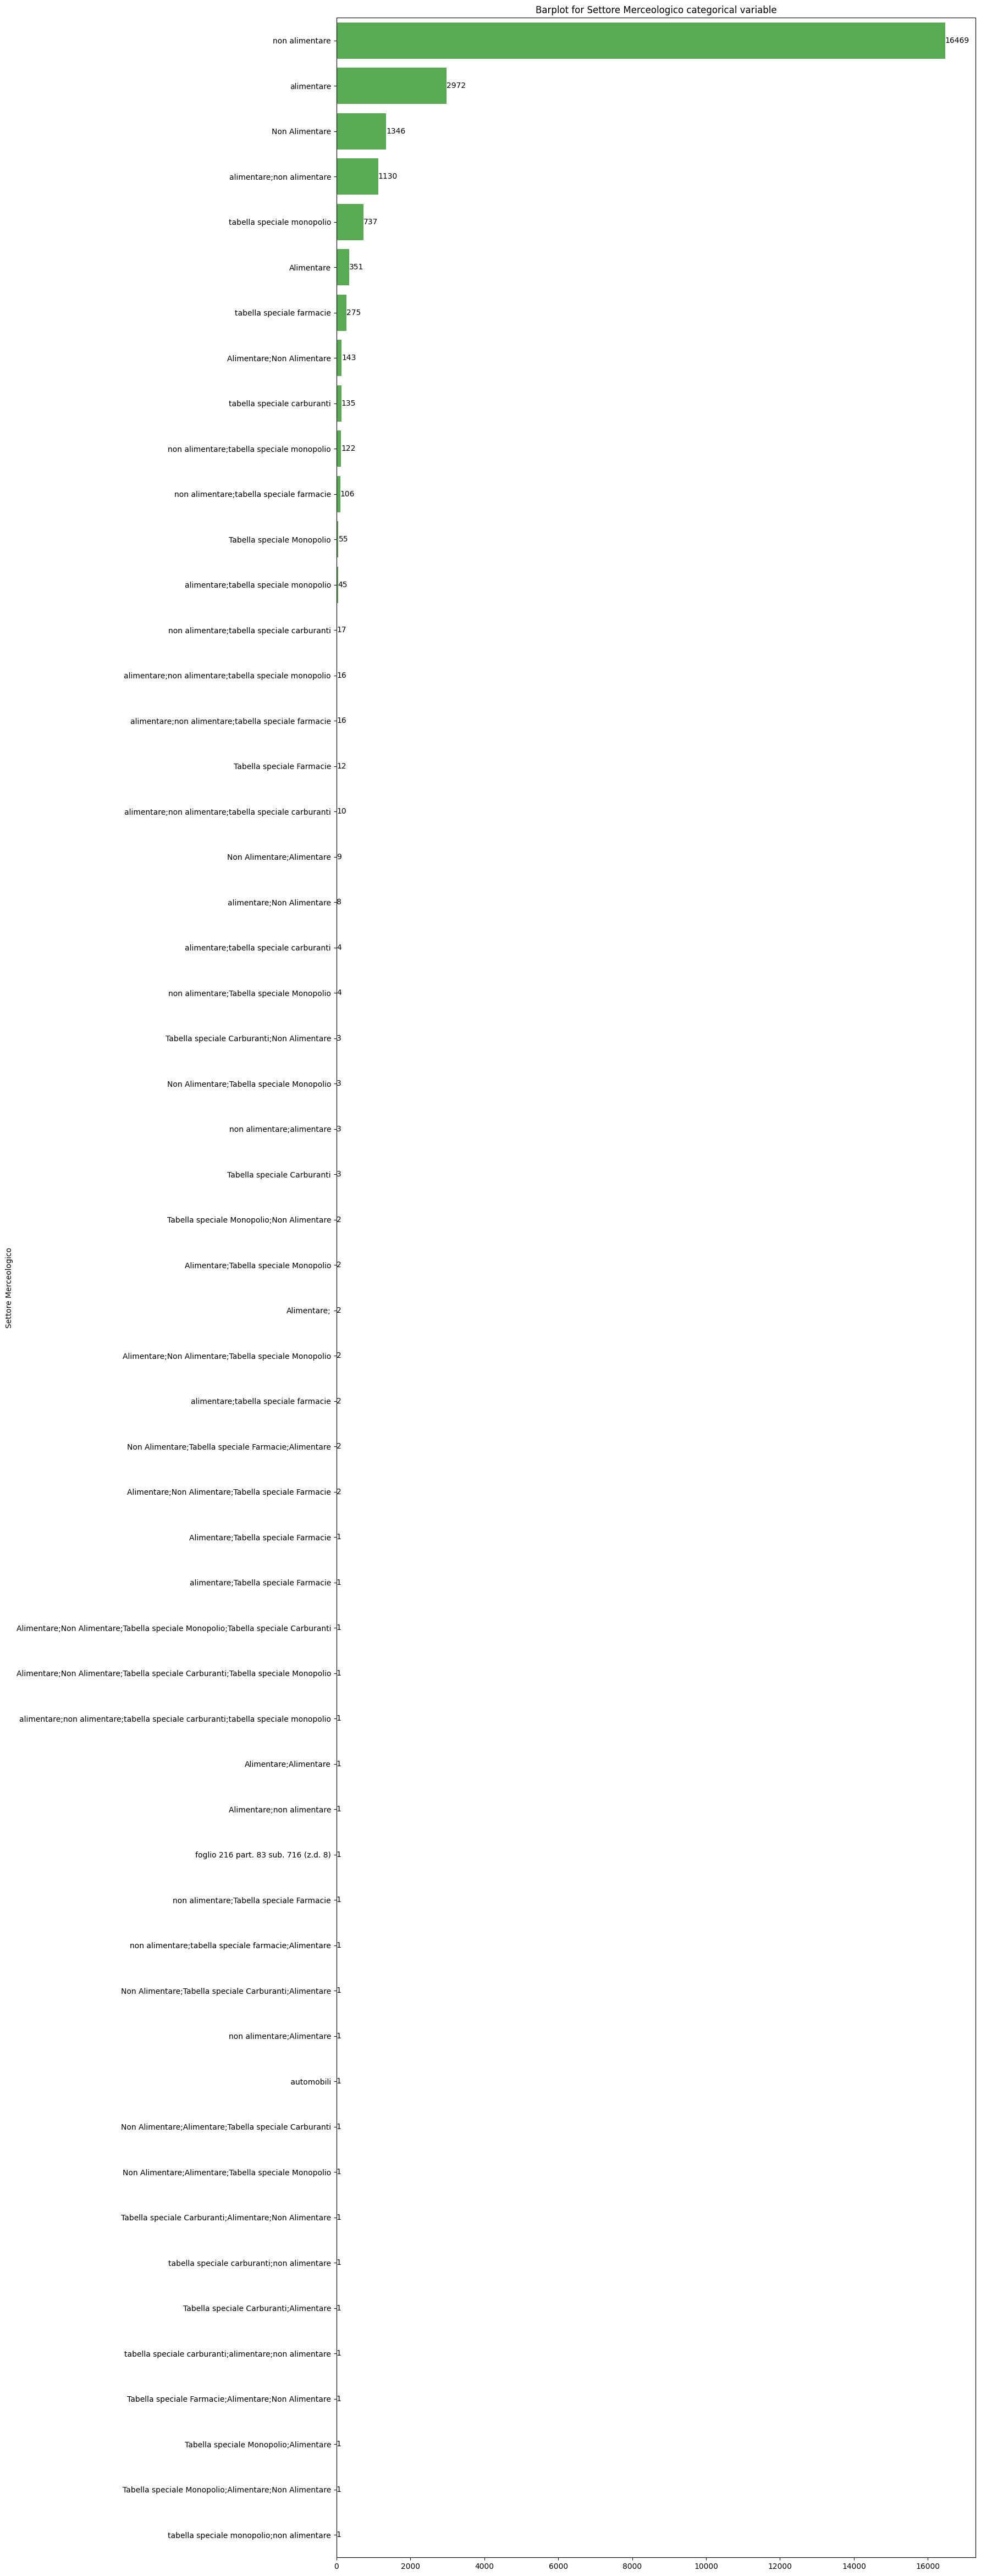

In [108]:
col ='Settore Merceologico'
plt.figure(figsize=(15,60))
ax = sns.barplot(x=df[col].value_counts().values, y=df[col].value_counts().index,
             errorbar=None, order=df[col].value_counts().index, color='#4CB944')
ax.bar_label(ax.containers[0], fontsize=10)
plt.title(f"Barplot for {col} categorical variable")
plt.ylabel(f"{col}")

In [109]:
cat.columns

Index(['Settore Merceologico', 'Insegna', 'Ubicazione', 'Tipo via', 'Via',
       'Civico', 'Codice via', 'ZD', 'Settore Storico Cf Preval'],
      dtype='object')

TODO Abbiamo troncato i valori ripetuti meno di 3 volte per una migliore visualzzazione

In [110]:
col ='Insegna'
# for visualization purposes
dft = df[col].value_counts() 
dft = dft[dft.values>3]
plt.figure(figsize=(100,100))
ax = sns.barplot(x=dft.values, y=dft.index,
             errorbar=None, color='#4CB944')
ax.bar_label(ax.containers[0], fontsize=50)
plt.title(f"Barplot for {col} categorical variable")
plt.yticks(fontsize=50)
plt.ylabel(f"{col}")

Text(0, 0.5, 'Insegna')

In [111]:
col ='Settore Storico Cf Preval'
# for visualization purposes
dft = df[col].value_counts() 
dft = dft[dft.values>50]
plt.figure(figsize=(100,100))
ax = sns.barplot(x=dft.values, y=dft.index,
             errorbar=None, color='#4CB944')
ax.bar_label(ax.containers[0], fontsize=50)
plt.title(f"Barplot for {col} categorical variable")
plt.yticks(fontsize=50)
plt.ylabel(f"{col}")

Text(0, 0.5, 'Settore Storico Cf Preval')

Text(0, 0.5, 'Tipo via')

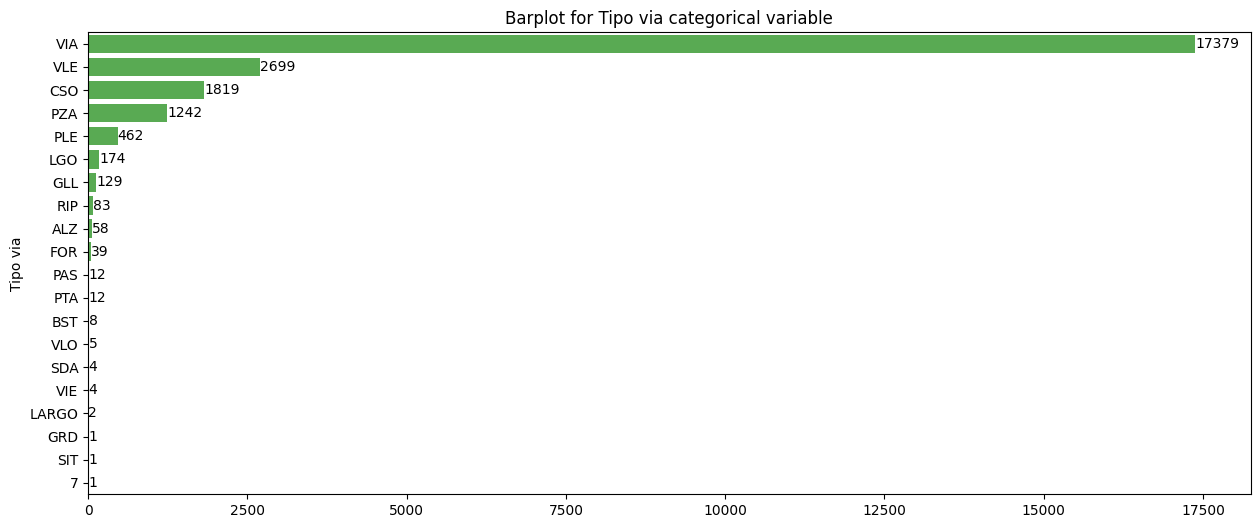

In [112]:
col ='Tipo via'
plt.figure(figsize=(15,6))
ax = sns.barplot(x=df[col].value_counts().values, y=df[col].value_counts().index,
             errorbar=None, order=df[col].value_counts().index, color='#4CB944')
ax.bar_label(ax.containers[0], fontsize=10)
plt.title(f"Barplot for {col} categorical variable")
plt.ylabel(f"{col}")

#### Spearman correlations between numerical variables

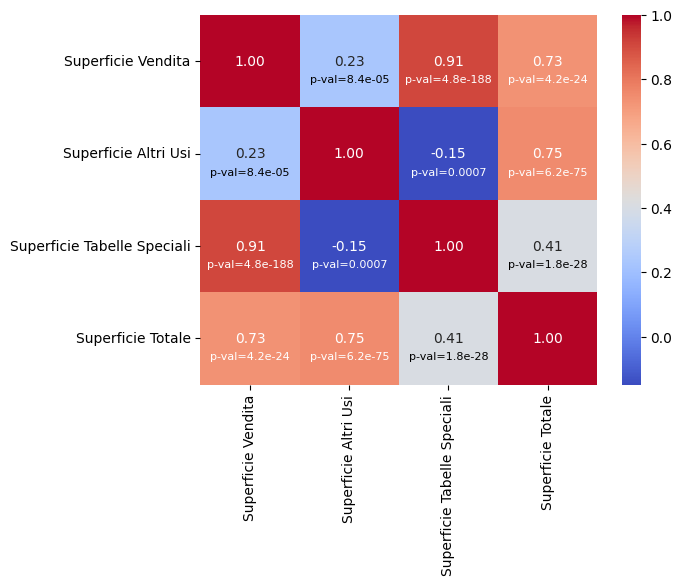

In [113]:
# Create the heatmap
corr = num.corr(method='spearman')

# Compute the p-values
p_values = pd.DataFrame(index=num.columns, columns=num.columns)
nnum = num.dropna()
for c1 in num.columns:
    for c2 in num.columns:
        if c1 == c2:
            p_values.loc[c1,c2] = 0.0
        else:
            _, p_value = spearmanr(nnum[c1], nnum[c2])
            p_values.loc[c1, c2] = p_value


sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
# Normalize the data for color contrast
norm = Normalize(vmin=corr.min().min(), vmax=corr.max().max())
cmap = plt.cm.coolwarm  
for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        if i != j: 
            color_value = norm(corr.iloc[i, j])
            color = cmap(color_value)

            # Decide font color based on cell background intensity
            text_color = 'white' if (color[0]*0.299 + color[1]*0.587 + color[2]*0.114) < 0.7 else 'black'
            plt.text(j + 0.5, i + 0.7, f"p-val={p_values.iloc[i, j]:.2g}", 
                     ha='center', va='center', fontsize=8, color=text_color)

#### Pearsons correlations between numerical variables

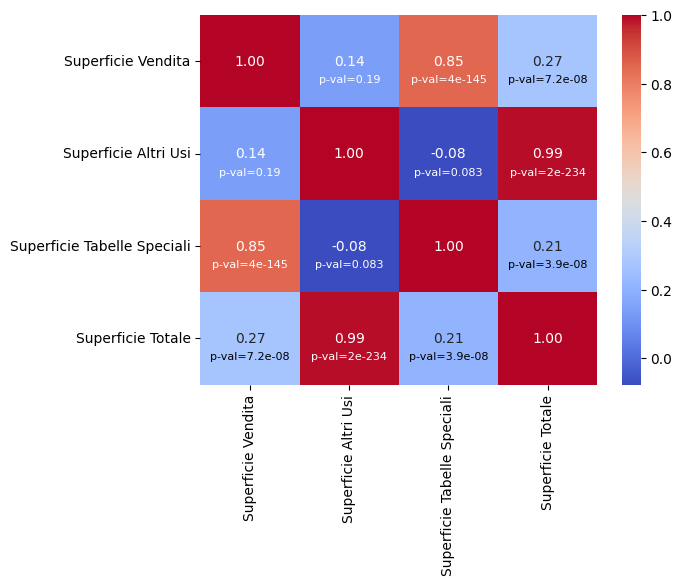

In [114]:
# Create the heatmap
corr = num.corr(method='pearson')

# Compute the p-values
p_values = pd.DataFrame(index=num.columns, columns=num.columns)
nnum = num.dropna()
for c1 in num.columns:
    for c2 in num.columns:
        if c1 == c2:
            p_values.loc[c1,c2] = 0.0
        else:
            _, p_value = pearsonr(nnum[c1], nnum[c2])
            p_values.loc[c1, c2] = p_value


sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
# Normalize the data for color contrast
norm = Normalize(vmin=corr.min().min(), vmax=corr.max().max())
cmap = plt.cm.coolwarm  
for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        if i != j: 
            color_value = norm(corr.iloc[i, j])
            color = cmap(color_value)

            # Decide font color based on cell background intensity
            text_color = 'white' if (color[0]*0.299 + color[1]*0.587 + color[2]*0.114) < 0.65 else 'black'
            plt.text(j + 0.5, i + 0.7, f"p-val={p_values.iloc[i, j]:.2g}", 
                     ha='center', va='center', fontsize=8, color=text_color)

## 2.3. Dependency Discovery
[$\leftarrow$ Back to contents](#Contents)

From a visual inspection of the dataset, the column `Ubicazione` seems to contain the information of the columns `Tipo via`, `Via`, `Civico`, `ZD`. Additionally, dataset contains 4 different columns for Superfici present in the dataset
* `Superficie Vendita`
* `Superficie Tabelle Speciali`
* `Superficie Altri Usi`
* `Superficie Totale` 

Looking the columns names the sum of the first three should be the 4th column.  
Other associations are spotted using `fpgrowth`.

In [115]:
def mine_association_rules(df,lhs,rhs,min_sup=0.5,min_conf=0.8,num_itemsets=2):

    """This function mines for association rules between arbitrary number of columns of a dataframe using fpgrowth algoithm to extract frequent itemsets."""
    
    #Put all items of each transactions into a list
    #df = df.dropna() # it makes everything explode apparently
    records = []
    for i in range(0,df.shape[0]):
        if type(lhs) == list:
            st1 = df.loc[i,lhs].str.cat(sep = ' ')
        else:
            st1 = str(df.loc[i,lhs])
        
        if type(rhs) == list:
            st2 = df.loc[i,rhs].str.cat(sep=' ')
        else:
            st2 = str(df.loc[i,rhs])

        records.append([(st1,0),(st2,1)])
    
    ### ASSOCIATION RULES MINING IN 3 STEPS ###

    # # 0 - generate an encoding of the dataset
    TE = TransactionEncoder()
    array = TE.fit(records).transform(records)
    array_df = pd.DataFrame(array,columns=TE.columns_)

    # 1 - generate the frequent itemset: set of transactions with support >= min_sup
    freq_itemset = fpgrowth(array_df, min_support=min_sup, use_colnames=True)
    freq_itemset['length'] = freq_itemset['itemsets'].apply(lambda x: len(x)) # additional column for length of itemset

    if not freq_itemset.empty:
        # 2 - generate rules: set of transactions having confidence >= min_conf
        rules = association_rules(freq_itemset, num_itemsets=num_itemsets, metric='confidence', min_threshold=min_conf)
        rules = rules[rules['lift']>1] # filter to keep only interesting rules

        # # clean up a bit the formats
        rules['antecedents'] = rules['antecedents'].apply(lambda x : list(x)[0])
        rules['consequents'] = rules['consequents'].apply(lambda x : list(x)[0])
        rules['antecedents'] = rules['antecedents'].apply(lambda x : tuple((str(lhs),x[0])) if x[1]==0 else tuple((str(rhs),x[0])))
        rules['consequents'] = rules['consequents'].apply(lambda x : tuple((str(lhs),x[0])) if x[1]==0 else tuple((str(rhs),x[0])))

        return pd.DataFrame([f"{x[0]} : {x[1]} => {y[0]} : {y[1]}" for x, y in rules[['antecedents','consequents']].values],columns=['rule'])
    else:
        return pd.DataFrame()



### 2.3.1. Codice Via and ZD
[$\leftarrow$ Back to contents](#Contents)  

195 rules were found, indicating that each `Codice via` is associated with only one `ZD`. The same goes for the association between `Via` and `ZD`, in fact `Codice via` should be univocally associated to the `Via`. Consequeltly, the number of rules found for the two associations is approximately the same.

In [116]:
codice_zd_rules = mine_association_rules(df,lhs='Codice via',rhs='ZD',min_sup=0.001)
codice_zd_rules.value_counts()

rule                       
Codice via : 1 => ZD : 1       1
Codice via : 1010 => ZD : 1    1
Codice via : 1016 => ZD : 1    1
Codice via : 1018 => ZD : 1    1
Codice via : 1028 => ZD : 1    1
                              ..
Codice via : 7300 => ZD : 8    1
Codice via : 7328 => ZD : 8    1
Codice via : 7390 => ZD : 8    1
Codice via : 7420 => ZD : 8    1
Codice via : 7478 => ZD : 8    1
Name: count, Length: 195, dtype: int64

In [117]:
via_zd_rules = mine_association_rules(df,lhs='Via',rhs='ZD',min_sup=0.001)
via_zd_rules.value_counts()

rule                               
Via : ABRUZZI => ZD : 3                1
Via : AMADEO GIAN ANTONIO => ZD : 3    1
Via : ANFOSSI AUGUSTO => ZD : 4        1
Via : ASELLI GASPARE => ZD : 3         1
Via : ASTESANI ALESSANDRO => ZD : 9    1
                                      ..
Via : VIGEVANO => ZD : 6               1
Via : VOLTA ALESSANDRO => ZD : 1       1
Via : VOLVINIO => ZD : 5               1
Via : WAGNER RICCARDO => ZD : 7        1
Via : ZURETTI GIANFRANCO => ZD : 2     1
Name: count, Length: 196, dtype: int64

### 2.3.2. Insegna and Settore Storico Cf Preval
[$\leftarrow$ Back to contents](#Contents)  

Most or the rules found are correlated with NaN values, especially for Insegna. This may indicate that shops associated with a particular Settore Storico don't have shop sign or it maybe it was not recorded.

In [118]:
sett_merc_sett_storico_rules = mine_association_rules(df,lhs='Insegna',rhs='Settore Storico Cf Preval',min_sup=0.001)
sett_merc_sett_storico_rules.value_counts()

rule                                                                                                                        
Insegna : bar tabacchi => Settore Storico Cf Preval : bar tabacchi                                                              1
Insegna : cartoleria => Settore Storico Cf Preval : cartoleria cancelleria                                                      1
Insegna : farmacia => Settore Storico Cf Preval : farmacia (articoli sussidiari)                                                1
Insegna : panetteria => Settore Storico Cf Preval : panetteria                                                                  1
Insegna : panificio => Settore Storico Cf Preval : panificio (con forno)                                                        1
Insegna : panificio pasticceria => Settore Storico Cf Preval : panificio (con forno)                                            1
Insegna : tabacchi => Settore Storico Cf Preval : articoli per fumatori                        

In [119]:
sett_merc_insegna_rules = mine_association_rules(df,lhs='Insegna',rhs='Settore Merceologico',min_sup=0.001)
sett_merc_insegna_rules.value_counts()

rule                                                                       
Insegna : bar tabacchi => Settore Merceologico : tabella speciale monopolio    1
Insegna : cartoleria => Settore Merceologico : non alimentare                  1
Insegna : farmacia => Settore Merceologico : tabella speciale farmacie         1
Insegna : macelleria => Settore Merceologico : alimentare                      1
Insegna : panetteria => Settore Merceologico : alimentare                      1
Insegna : panificio => Settore Merceologico : alimentare                       1
Insegna : panificio pasticceria => Settore Merceologico : alimentare           1
Insegna : tabacchi => Settore Merceologico : tabella speciale monopolio        1
Settore Merceologico : Alimentare => Insegna : nan                             1
Settore Merceologico : Alimentare;Non Alimentare => Insegna : nan              1
Settore Merceologico : Non Alimentare => Insegna : nan                         1
Settore Merceologico : nan => Ins

### 2.3.3. Settore Merceologico and Settore Storico Cf Preval
[$\leftarrow$ Back to contents](#Contents)  

24 rules are found with a minimum support of 0.01 (10 times higher than the one used for spotting rules in the previous cases). This is an interesting result, especially considering that no data wrangling was applied.

In [120]:
sett_merc_sett_storico_rules = mine_association_rules(df,lhs='Settore Merceologico',rhs='Settore Storico Cf Preval',min_sup=0.01)
sett_merc_sett_storico_rules.value_counts()

rule                                                                                                                
Settore Merceologico : tabella speciale farmacie => Settore Storico Cf Preval : farmacia (articoli sussidiari)          1
Settore Storico Cf Preval : abbigliamento => Settore Merceologico : non alimentare                                      1
Settore Storico Cf Preval : accessori e ricambi auto-moto => Settore Merceologico : non alimentare                      1
Settore Storico Cf Preval : antichita' e oggetti d'arte,an => Settore Merceologico : non alimentare                     1
Settore Storico Cf Preval : articoli regalo => Settore Merceologico : non alimentare                                    1
Settore Storico Cf Preval : autoveicoli => Settore Merceologico : non alimentare                                        1
Settore Storico Cf Preval : bar tabacchi => Settore Merceologico : tabella speciale monopolio                           1
Settore Storico Cf Preval : c

In [121]:
len(sett_merc_sett_storico_rules)

22

# 3. DQ assesment
[$\leftarrow$ Back to contents](#Contents)

The 4 main dimensions to evaluate are:
- completeness
- accuracy (can't evaluate since there's no ground truth)
- timeliness
- consistency

## 3.1. Cardinality and Completeness
[$\leftarrow$ Back to contents](#Contents)

In [122]:
# single column assesment
dq_assesment_sc = pd.DataFrame(columns=df.columns,index=['Uniqueness','Distinctness','Constancy'])

for col in df.columns:
    uniqueness = sc_analysis.loc['Cardinality',col]/n_rows
    distinctness = sc_analysis.loc['Cardinality',col]/sc_analysis.loc['Actual',col]
    mode = df[col].mode()[0]
    constancy = df[col].value_counts()[mode] / n_rows

    dq_assesment_sc.loc['Uniqueness', col] = uniqueness
    dq_assesment_sc.loc['Distinctness', col] = distinctness
    dq_assesment_sc.loc['Constancy', col] = constancy
    
dq_assesment_sc


Settore Merceologico   Insegna Ubicazione  Tipo via       Via  \
Uniqueness                0.00232  0.231314   0.700489  0.000829  0.096578   
Distinctness              0.00233  0.798827   0.700518  0.000829  0.096582   
Constancy                0.682342  0.006878   0.000953  0.720045   0.01214   

                Civico Codice via        ZD Settore Storico Cf Preval  \
Uniqueness    0.015993   0.097282  0.000414                   0.09231   
Distinctness  0.016435    0.09729  0.000414                  0.092437   
Constancy     0.062314    0.01214  0.237488                  0.089617   

             Superficie Vendita Superficie Altri Usi  \
Uniqueness             0.010358             0.018147   
Distinctness           0.010371             0.048462   
Constancy              0.051583             0.024196   

             Superficie Tabelle Speciali Superficie Totale  
Uniqueness                      0.004848          0.026599  
Distinctness                    0.103815          0.026639  
Constancy                       0.004267          0.042551

In [123]:
completeness = df.notnull().sum().sum()/np.prod(df.shape)
print(f"COMPLETENESS: {completeness}")

COMPLETENESS: 0.8211544835674766


## 3.2. Consistency
[$\leftarrow$ Back to contents](#Contents)  

To evaluate dataset consistency, both the dependencies that were spotted visually and the dependencies analyzed by association rules are checked for each row in the dataset. A dataset containing rows with inconsistencies is saved to be studied later, after data wrangling. A column named `Reason` is added to the `df_inconsistencies` to keep trace of the checks that failed during consistency assessment.

In [124]:
df_inconsistencies = pd.DataFrame(columns = df.columns)
df_inconsistencies['Reason'] = pd.Series()

In [125]:
consistency_sum = 0

for i, r in df.iterrows():
    ub = r['Ubicazione']
    tipo = r['Tipo via']
    via = r['Via']
    civ = r['Civico']
    codvia = r['Codice via']
    zd = r['ZD']

    flag = 0
    reason = ''

    # check of Ubicazione contains other columns
    if isinstance(ub,str):
        if isinstance(tipo,str):
            if str(tipo) in ub:
                consistency_sum = consistency_sum + 0.14
            else:
                flag = 1
                reason = f"{reason}Tipo via, "
        if isinstance(via,str):
            if str(via) in ub:
                consistency_sum = consistency_sum + 0.14
            else:
                flag = 1
                reason = f"{reason}Nome via, " 
        if isinstance(civ,str):
            if (str(civ) in ub):
                consistency_sum = consistency_sum + 0.14
            else:
                flag = 1
                reason = f"{reason}Civico, "
        if isinstance(zd,str):
            if (str(zd) in ub):
                consistency_sum = consistency_sum + 0.14
            else:
                flag = 1
                reason = f"{reason}ZD not in Ubicazione, "
    
    # Z.D. has to be a zone number
    if zd in {'1','2','3','4','5','6','7','8','9'}:
        consistency_sum = consistency_sum + 0.15
    else:
        flag = 1
        reason = f"{reason}ZD messed zone number, "
        
    # check of rule: Codice via => ZD
    rule_values = codice_zd_rules['rule'].str.extract(r'[A-Za-z]+\s\:\s(.*)\s\=\>\s[A-Za-z]+\s\:\s(.*)',expand=True)
    value = rule_values[rule_values[0]==zd].reset_index()

    if not value.empty:
        if zd == value[1][0]:
            consistency_sum = consistency_sum + 0.14
        else:
            flag = 1
            reason = f"{reason}Codice via, "

    # check sum of coherency between superificie filds
    sv = r['Superficie Vendita']
    sa = r['Superficie Altri Usi']
    ss = r['Superficie Tabelle Speciali']
    st = r['Superficie Totale']
    
    if (sv+sa+ss) == st:
        consistency_sum = consistency_sum + 0.15
    #elif not np.isnan(sv+sa+ss):
    else:
        flag = 1
        reason = f"{reason}Superficie, "
    
    if flag == 1:
        r['Reason'] = reason
        df_inconsistencies = df_inconsistencies._append(r)

`1213` rows with inconsistencies were found, the most recurrent inconsistency is related to the sum of `Superficie Vendita`, `Superficie Tabelle Speciali` and `Superficie Altri Usi` that does not match `Superficie Totale`.

In [79]:
print(f"Number of inconsistent rows: {df_inconsistencies.shape[0]}")
print(df_inconsistencies['Reason'].value_counts())

Number of inconsistent rows: 1213
Reason
Superficie,                                                                  491
Tipo via, Nome via, Civico,                                                  264
Nome via, Civico,                                                            206
ZD not in Ubicazione,                                                        109
Tipo via, Nome via,                                                           79
Nome via,                                                                     36
Civico,                                                                       10
Tipo via, Nome via, Civico, Superficie,                                        6
Nome via, Civico, Superficie,                                                  3
Tipo via, Nome via, Superficie,                                                3
ZD messed zone number,                                                         2
Tipo via, Nome via, Civico, ZD not in Ubicazione, ZD messed zone num

In [80]:
consistency = consistency_sum/df.shape[0]
consistency

0.7303940172345144

# 4. Data Wrangling
[$\leftarrow$ Back to contents](#Contents)

In [81]:
# Create a copy of the original df
df_original = df.copy()

## 4.1. Settore Merceologico
[$\leftarrow$ Back to contents](#Contents)

1. All values of the column are put in lower case
2. Some entries have multiple values in the column `Settore Merceologico` separated with `;`. Therefore, the column is split into `Settore Merceologico Primario` and `Settore Merceologico Secondario` (which may include multiple values).
3. For `Settore Merceologico secondario`, the separator for multiple values is changed from `;` to `, `
4. The column `Settore Merceologico` is dropped and the two new columns are moved to position `0` and `1`.

In [82]:
# Put all values in lower case
df['Settore Merceologico'] = df['Settore Merceologico'].str.lower()

# Add additional columns for Settore Merceologico Principale and Settore Merceologico Secondario

df[['Settore Merceologico Principale', 'Settore Merceologico Secondario']] = (
    df['Settore Merceologico']
    .str.split(';', n=1, expand=True)
    .apply(lambda x: [x[0], x[1] if len(x) > 1 else np.nan], axis=1, result_type='expand')
)
df['Settore Merceologico Secondario'] = df['Settore Merceologico Secondario'].astype(object).replace({None: np.nan})
df['Settore Merceologico Secondario'] = df['Settore Merceologico Secondario'].str.replace(';',', ')

# Drop the origilal column Settore Merceologico
df = df.drop(columns='Settore Merceologico')

# Insert the two new columns in position 0 and 1
df.insert(0,'Settore Merceologico Principale', df.pop('Settore Merceologico Principale'))
df.insert(1, 'Settore Merceologico Secondario', df.pop('Settore Merceologico Secondario'))
df.iloc[5000:5010]


Settore Merceologico Principale Settore Merceologico Secondario Insegna  \
5000                  non alimentare                             NaN     NaN   
5001                  non alimentare                             NaN     NaN   
5002                  non alimentare                             NaN     NaN   
5003                  non alimentare                             NaN     NaN   
5004                  non alimentare                             NaN     NaN   
5005                  non alimentare                             NaN     NaN   
5006                  non alimentare                             NaN     NaN   
5007                  non alimentare                             NaN     NaN   
5008                  non alimentare                             NaN     NaN   
5009                  non alimentare                             NaN     NaN   

                                             Ubicazione Tipo via  \
5000    CSO DI PORTA NUOVA 1ø piano num.046/b; (z.d. 1)      CSO   
5001  CSO DI PORTA NUOVA N. 19 ; isolato:009; access...      CSO   
5002  CSO DI PORTA NUOVA N. 32 ; isolato:088; access...      CSO   
5003  CSO DI PORTA NUOVA N. 32 ; isolato:088; access...      CSO   
5004                  CSO DI PORTA NUOVA N. 34 (z.d. 1)      CSO   
5005                  CSO DI PORTA NUOVA N. 34 (z.d. 1)      CSO   
5006  CSO DI PORTA NUOVA N. 38 ;cso di porta romana ...      CSO   
5007  CSO DI PORTA NUOVA N. 38 ; isolato:088; access...      CSO   
5008                  CSO DI PORTA NUOVA N. 38 (z.d. 1)      CSO   
5009  CSO DI PORTA NUOVA N. 46 ; isolato:010; access...      CSO   

                 Via Civico Codice via ZD       Settore Storico Cf Preval  \
5000  DI PORTA NUOVA    NaN       1044  1  antichita' e oggetti d'arte,an   
5001  DI PORTA NUOVA     19       1044  1               articoli sanitari   
5002  DI PORTA NUOVA     32       1044  1                articoli funebri   
5003  DI PORTA NUOVA     32       1044  1                     coltelleria   
5004  DI PORTA NUOVA     34       1044  1                   abbigliamento   
5005  DI PORTA NUOVA     34       1044  1                     autovetture   
5006  DI PORTA NUOVA     38       1044  1                   abbigliamento   
5007  DI PORTA NUOVA     38       1044  1                 galleria d'arte   
5008  DI PORTA NUOVA     38       1044  1          vendita oggetti d'arte   
5009  DI PORTA NUOVA     46       1044  1                articoli funebri   

      Superficie Vendita  Superficie Altri Usi  Superficie Tabelle Speciali  \
5000               200.0                  40.0                          NaN   
5001                20.0                 506.0                          NaN   
5002                32.0                   NaN                          NaN   
5003                22.0                   6.0                          NaN   
5004               127.0                   NaN                          NaN   
5005                36.0                   NaN                          NaN   
5006                60.0                  20.0                          NaN   
5007                70.0                   NaN                          NaN   
5008               150.0                  60.0                          NaN   
5009                37.0                   NaN                          NaN   

      Superficie Totale  
5000              240.0  
5001              526.0  
5002               32.0  
5003               28.0  
5004              329.0  
5005               74.0  
5006               80.0  
5007               70.0  
5008              210.0  
5009               37.0

## 4.2. Insegna
[$\leftarrow$ Back to contents](#Contents)

1. Values were put to lower case
2. Everything different from alphanumeric characters or `.` was replaced with ` `.

In [83]:
# Put all values to loewer case
df['Insegna'] = df['Insegna'].str.lower()

# Replace not alphanumeric characters(or stop) with spaces.
df['Insegna'] = df['Insegna'].str.replace('[^(\.\w)]',' ',regex=True)

df.iloc[100:105]

Settore Merceologico Principale Settore Merceologico Secondario  \
100                             NaN                             NaN   
101                             NaN                             NaN   
102                             NaN                             NaN   
103                             NaN                             NaN   
104                             NaN                             NaN   

                   Insegna                                         Ubicazione  \
100    produttore agricolo  VIA RIPAMONTI GIUSEPPE N. 549 7.4.08 tras.set....   
101    produttore agricolo  VIA SELVANESCO N. 25 7.4.08 tras.set. agricolt...   
102    produttore agricolo  VLE TROYA CARLO N. 23 7.4.08 tras.sett.agricol...   
103  specialita  regionali  VIA SAMMARTINI GIOVANNI BATTISTA N. 69 ; isola...   
104                tessuti  VIA MUZIO SCEVOLA N. 4 ; isolato:115; accesso:...   

    Tipo via                           Via Civico Codice via ZD  \
100      VIA            RIPAMONTI GIUSEPPE    549       4066  5   
101      VIA                    SELVANESCO     25       4350  5   
102      VLE                   TROYA CARLO     23       5140  6   
103      VIA  SAMMARTINI GIOVANNI BATTISTA     69       1202  2   
104      VIA                 MUZIO SCEVOLA      4       2663  3   

     Settore Storico Cf Preval  Superficie Vendita  Superficie Altri Usi  \
100             fiori e piante                 0.0                   NaN   
101   frutta, verdura e funghi                 0.0                   NaN   
102   frutta, verdura e funghi                 0.0                   NaN   
103      panificio (con forno)                18.0                   NaN   
104  tessuti per abbigliamento                18.0                   NaN   

     Superficie Tabelle Speciali  Superficie Totale  
100                          NaN                0.0  
101                          NaN                0.0  
102                          NaN                0.0  
103                          NaN               18.0  
104                          NaN               18.0

## 4.3. Ubicazione
[$\leftarrow$ Back to contents](#Contents)

From a visual inspection it was noted that the column Ubicazione contained some information already present in other columns and in some cases some additional information. Information is usually separated by `;`. This column may be useful for handling missing values by performing data imputation. For this reason, the information in this column is saved in a temporary `DataFrame` split into:
* `Tipo via tmp`
* `Via tmp`
* `Civico tmp`
* `ZD tmp ` 

Of a note, two columns not present in the original `DataFrame` emerged:
* `Accesso`
* `Isolato`
* `Website`

Additional information was put into the column `Altre info`.  
The columns of the temporary DataFrame are concatenated to the complete `DataFrame` next to the column `ZD`. In the end, the column Ubicazione is dropped from the complete `DataFrame`.

In [84]:
# Create the temporary DataFrame
dft = pd.DataFrame()

# Extract Tipo via
dft['Tipo via tmp'] = df['Ubicazione'].str.extract('([A-Z]+ )',expand=True)

# Extract Via
dft['Via tmp'] = df['Ubicazione'].str.extract(r'(?:^[A-Z]+ )([A-Z\.\'\s]+[A-MO-Z\']+[\.N]*)(?= N\.|num\.|civ\.|civico|\s?[a-z]|\s?\W\d)', expand=True)
dft['Via tmp'] = dft['Via tmp'].str.strip() # Remove spaces at the begin and end of the string

# Extract Civico
dft['Civico tmp'] = df['Ubicazione'].str.extract(r'(?:N\.|num\.|civ\.|civico)(\s?[\w/\\]+)', expand=True)
dft['Civico tmp'] = dft['Civico tmp'].str.strip() # Remove spaces at the begin and end of the string
dft['Civico tmp'] = dft['Civico tmp'].str.upper() # Put all characters to uppercase
dft['Civico tmp'] = dft['Civico tmp'].replace(r'^0+', '', regex=True) # Remove all the zeros at the beginning of the string
dft.loc[dft['Civico tmp'] == '','Civico tmp'] = np.nan # If the string is empty, replace with NaN

# Extract ZD
dft['ZD tmp'] = df['Ubicazione'].str.extract('\(z.d. (\d)\)',expand=True)
dft['ZD tmp'] = dft['ZD tmp'].str.strip() # Remove spaces at the begin and end of the string

# Extract Accesso
dft['Accesso'] = df['Ubicazione'].str.extract(r'accesso:([^;]*)')
dft['Accesso'] = dft['Accesso'].str.strip() # Remove spaces at the begin and end of the string
dft['Accesso'] = dft['Accesso'].replace(r'^accesso ', '', regex=True) # Remove the word accesso from the beginning of the string

# Extract Isolato
dft['Isolato'] = df['Ubicazione'].str.extract(r'isolato:([^;]*)')
dft['Isolato'] = dft['Isolato'].str.strip() # Remove spaces at the begin and end of the string
dft['Isolato'] = dft['Isolato'].replace(r'^0+', '', regex=True) # Remove all the zeros at the beginning of the string

# Extract Website
dft['Website'] = df['Ubicazione'].str.extract(r'(www[\w\.-]+)', expand=True)
dft['Website'] = dft['Website'].str.strip() # Remove spaces at the begin and end of the string

# Extract Altre info
dft['Altre info'] = df['Ubicazione'].replace({
    r'\(z.d. (\d)\)': '',  # Remove ZD info
    r'accesso:([^;]*)': '', # Remove Accesso info
    r'isolato:([^;]*)': '',  # Remove Isolato info
    r'([A-Z\.\'\s]+[A-Z\']+)(?= N\.|num\.|civ\.|civico|\s?[a-z]|\s?\W\d)': '', # remove Via info
    r'(N\.|num\.|civ\.|civico)(\s?[\w/\\]+)': '', # remove Civico info
    r'(www[\w\.-]+)': ''  # Remove Website info
}, regex=True)
dft['Altre info'] = dft['Altre info'].str.strip() # Strip any extra spaces from the remaining string
dft['Altre info'] = dft['Altre info'].replace(r'^[; ]+|[; ]+$', '', regex=True)  # Remove leading/trailing ; and spaces
dft['Altre info'] = dft['Altre info'].replace(r';+', '', regex=True)  # Replace multiple semicolons with a single one

# Set the rows with empty Altre info as nan
dft.loc[dft['Altre info'] == '','Altre info'] = np.nan

dft.head(20)

Tipo via tmp                       Via tmp Civico tmp ZD tmp  Accesso  \
0          CSO                         ITALIA         34      1      NaN   
1          CSO                           LODI        104      4      NaN   
2          CSO                           LODI         26      5      NaN   
3          CSO                       SEMPIONE         41      6      NaN   
4          LGO   SCALABRINI GIOVANNI BATTISTA          2      6      NaN   
5          PLE       STAZIONE DI PORTA GENOVA          2      6      NaN   
6          PZA                     ASPROMONTE          1      3  esterno   
7          PZA              BONOMELLI GEREMIA         10      5      NaN   
8          PZA              OBERDAN GUGLIELMO          2      1      NaN   
9          PZA       SANTA MARIA DELLE GRAZIE          1      1      NaN   
10         PZA               VIGILI DEL FUOCO         10      3  esterno   
11         VIA           ABBA GIUSEPPE CESARE         32      9      NaN   
12         VIA                AIRAGHI GAETANO         49      7      NaN   
13         VIA                AIRAGHI GAETANO         49      7      NaN   
14         VIA                   ANELLI LUIGI          2      1      NaN   
15         VIA              ARCONATI COSTANZA          2      4      NaN   
16         VIA                        AUSONIO         23      1      NaN   
17         VIA                        BENGASI          2      1      NaN   
18         VIA              BONCOMPAGNI CARLO         55      4      NaN   
19         VIA                 CANONICA LUIGI         81      8      NaN   

   Isolato Website                      Altre info  
0      NaN     NaN                             NaN  
1      NaN     NaN                             NaN  
2      NaN     NaN                             NaN  
3      NaN     NaN                             NaN  
4      NaN     NaN                             NaN  
5      NaN     NaN                             NaN  
6       41     NaN  ang.lulli-7.4.08 tr.set.agrico  
7      NaN     NaN                             NaN  
8      NaN     NaN                             NaN  
9      NaN     NaN               comm. elettronico  
10      91     NaN                             NaN  
11      58     NaN     7.4.08 tras.set.agricoltura  
12     NaN     NaN             produttore agricolo  
13     NaN     NaN                             NaN  
14     120     NaN                             NaN  
15     NaN     NaN                             NaN  
16     NaN     NaN                             NaN  
17     NaN     NaN                             NaN  
18     NaN     NaN                             NaN  
19     104     NaN     7.4.08 tras.set.agricoltura

In [85]:
# Wrong entry found with visual inspection
df.iloc[10008]

Settore Merceologico Principale                foglio 216 part. 83 sub. 716 (z.d. 8)
Settore Merceologico Secondario                                                  NaN
Insegna                                                                          via
Ubicazione                                                                  GROSOTTO
Tipo via                                                                           7
Via                                                                             7328
Civico                                                                             8
Codice via                         vendita al dettaglio di prodotti del settore n...
ZD                                                                                60
Settore Storico Cf Preval                                                        NaN
Superficie Vendita                                                               NaN
Superficie Altri Usi                                             

In [86]:
# Add tmp columns to the original df
for i, colname in enumerate(dft.columns):
    df.insert(9 + i, colname, dft[colname])
df

Settore Merceologico Principale Settore Merceologico Secondario  \
0                                 NaN                             NaN   
1                                 NaN                             NaN   
2                                 NaN                             NaN   
3                                 NaN                             NaN   
4                                 NaN                             NaN   
...                               ...                             ...   
24131      tabella speciale monopolio                      alimentare   
24132      tabella speciale monopolio      alimentare, non alimentare   
24133      tabella speciale monopolio                  non alimentare   
24134      tabella speciale monopolio                  non alimentare   
24135      tabella speciale monopolio                  non alimentare   

             Insegna                                         Ubicazione  \
0                NaN                          CSO ITALIA N. 34 (z.d. 1)   
1                NaN                           CSO LODI N. 104 (z.d. 4)   
2                NaN                            CSO LODI N. 26 (z.d. 5)   
3                NaN                        CSO SEMPIONE N. 41 (z.d. 6)   
4                NaN     LGO SCALABRINI GIOVANNI BATTISTA N. 2 (z.d. 6)   
...              ...                                                ...   
24131            NaN  RIP DI PTA TICINESE N. 61 ; isolato:071; acces...   
24132           i.p.  VIA GALVANI LUIGI N. 34 ; isolato:238; accesso...   
24133  tabacchi noli  VIA MARINO TOMMASO N. 7 ;gll vittorio emanuele...   
24134            NaN                  VIA ASELLI GASPARE N. 11 (z.d. 3)   
24135            NaN                     VLE MONTE GRAPPA N. 2 (z.d. 9)   

      Tipo via                           Via Civico Codice via ZD  \
0          CSO                        ITALIA     34        526  1   
1          CSO                          LODI    104       4068  4   
2          CSO                          LODI     26       4068  5   
3          CSO                      SEMPIONE     41       7137  8   
4          LGO  SCALABRINI GIOVANNI BATTISTA      2       5392  6   
...        ...                           ...    ...        ... ..   
24131      RIP               DI PTA TICINESE     61       5150  6   
24132      VIA                 GALVANI LUIGI     34       1179  2   
24133      VIA                MARINO TOMMASO      7        204  1   
24134      VIA                ASELLI GASPARE     11       3167  3   
24135      VLE                  MONTE GRAPPA      2       1101  9   

      Tipo via tmp  ... ZD tmp  Accesso Isolato Website  \
0             CSO   ...      1      NaN     NaN     NaN   
1             CSO   ...      4      NaN     NaN     NaN   
2             CSO   ...      5      NaN     NaN     NaN   
3             CSO   ...      6      NaN     NaN     NaN   
4             LGO   ...      6      NaN     NaN     NaN   
...            ...  ...    ...      ...     ...     ...   
24131         RIP   ...      6  esterno      71     NaN   
24132         VIA   ...      2  esterno     238     NaN   
24133         VIA   ...      1  esterno     415     NaN   
24134         VIA   ...      3      NaN     NaN     NaN   
24135         VLE   ...      9      NaN     NaN     NaN   

                      Altre info  Settore Storico Cf Preval  \
0                            NaN      speciale panificatori   
1                            NaN                        NaN   
2                            NaN      speciale panificatori   
3                            NaN                        NaN   
4                            NaN                        NaN   
...                          ...                        ...   
24131                        NaN     cartoleria cancelleria   
24132                        NaN  carburanti e lubrificanti   
24133  gll vittorio emanuele 000      articoli per fumatori   
24134                        NaN     commercio al dettaglio 

In [87]:
# Drop the column Ubicazione
df = df.drop(columns=["Ubicazione"])
df.head(5)

Settore Merceologico Principale Settore Merceologico Secondario Insegna  \
0                             NaN                             NaN     NaN   
1                             NaN                             NaN     NaN   
2                             NaN                             NaN     NaN   
3                             NaN                             NaN     NaN   
4                             NaN                             NaN     NaN   

  Tipo via                           Via Civico Codice via ZD Tipo via tmp  \
0      CSO                        ITALIA     34        526  1         CSO    
1      CSO                          LODI    104       4068  4         CSO    
2      CSO                          LODI     26       4068  5         CSO    
3      CSO                      SEMPIONE     41       7137  8         CSO    
4      LGO  SCALABRINI GIOVANNI BATTISTA      2       5392  6         LGO    

                        Via tmp  ... ZD tmp Accesso Isolato Website  \
0                        ITALIA  ...      1     NaN     NaN     NaN   
1                          LODI  ...      4     NaN     NaN     NaN   
2                          LODI  ...      5     NaN     NaN     NaN   
3                      SEMPIONE  ...      6     NaN     NaN     NaN   
4  SCALABRINI GIOVANNI BATTISTA  ...      6     NaN     NaN     NaN   

  Altre info Settore Storico Cf Preval Superficie Vendita  \
0        NaN     speciale panificatori                0.0   
1        NaN                       NaN               16.0   
2        NaN     speciale panificatori                0.0   
3        NaN                       NaN              120.0   
4        NaN                       NaN                0.0   

   Superficie Altri Usi  Superficie Tabelle Speciali  Superficie Totale  
0                   NaN                          NaN                0.0  
1                   5.0                          NaN               21.0  
2                   NaN                          NaN                0.0  
3                   NaN                          NaN              120.0  
4                   NaN                          NaN                0.0  

[5 rows x 21 columns]

## 4.4. Tipo via, Via, Civico, Codice via, Settore Storico Cf Preval
[$\leftarrow$ Back to contents](#Contents)  

The following operations are applied:
* `Tipo Via`, `Via`, `Civico`: Remove spaces at the beginning and at the end of the string, conversion of all alphabetic characters to caps.
* `Codice Via`: Remove spaces at the beginning and at the end of the string
* `Settore Storico Cf Preval`: Remove spaces at the beginning and at the end of the string, conversion of all alphabetic characters to lower case.

In [88]:
# Wrangling of Tipo via
df['Tipo via'] = df['Tipo via'].str.strip().str.upper()

# Wrangling of Via
df['Via'] = df['Via'].str.strip().str.upper()

# Wrangling of Civico
df['Civico'] = df['Civico'].str.strip().str.upper()

# Wrangling of Codice via
df['Codice via'] = df['Codice via'].str.strip()

# Wrangling of Settore Storico Cf Preval
df['Settore Storico Cf Preval'] = df['Settore Storico Cf Preval'].str.strip().str.lower()

df.head(5)

Settore Merceologico Principale Settore Merceologico Secondario Insegna  \
0                             NaN                             NaN     NaN   
1                             NaN                             NaN     NaN   
2                             NaN                             NaN     NaN   
3                             NaN                             NaN     NaN   
4                             NaN                             NaN     NaN   

  Tipo via                           Via Civico Codice via ZD Tipo via tmp  \
0      CSO                        ITALIA     34        526  1         CSO    
1      CSO                          LODI    104       4068  4         CSO    
2      CSO                          LODI     26       4068  5         CSO    
3      CSO                      SEMPIONE     41       7137  8         CSO    
4      LGO  SCALABRINI GIOVANNI BATTISTA      2       5392  6         LGO    

                        Via tmp  ... ZD tmp Accesso Isolato Website  \
0                        ITALIA  ...      1     NaN     NaN     NaN   
1                          LODI  ...      4     NaN     NaN     NaN   
2                          LODI  ...      5     NaN     NaN     NaN   
3                      SEMPIONE  ...      6     NaN     NaN     NaN   
4  SCALABRINI GIOVANNI BATTISTA  ...      6     NaN     NaN     NaN   

  Altre info Settore Storico Cf Preval Superficie Vendita  \
0        NaN     speciale panificatori                0.0   
1        NaN                       NaN               16.0   
2        NaN     speciale panificatori                0.0   
3        NaN                       NaN              120.0   
4        NaN                       NaN                0.0   

   Superficie Altri Usi  Superficie Tabelle Speciali  Superficie Totale  
0                   NaN                          NaN                0.0  
1                   5.0                          NaN               21.0  
2                   NaN                          NaN                0.0  
3                   NaN                          NaN              120.0  
4                   NaN                          NaN                0.0  

[5 rows x 21 columns]

## 4.5. Superficie
[$\leftarrow$ Back to contents](#Contents)

To better understand which relationship there is between the four columns, and therefore how to apply data wrangling, different sums of the first three are computed to discover the most likely formula used to compute Superficie Totale. 
* `Sup Tot1`: sum of the three columns
* `Sup Tot2`: sum of `Superficie Vendita` and `Superficie Altri Usi`, assuming that `Superficie Tabelle Speciali` is included in `Superficie Vendita`

In [89]:
df['Sup Tot1'] = df['Superficie Vendita'].add(df['Superficie Tabelle Speciali'], fill_value=0)
df['Sup Tot1'] = df['Sup Tot1'].add(df['Superficie Altri Usi'], fill_value=0)
df['Sup Tot2'] = df['Superficie Vendita'].add(df['Superficie Altri Usi'], fill_value=0)
df.head(5)

Settore Merceologico Principale Settore Merceologico Secondario Insegna  \
0                             NaN                             NaN     NaN   
1                             NaN                             NaN     NaN   
2                             NaN                             NaN     NaN   
3                             NaN                             NaN     NaN   
4                             NaN                             NaN     NaN   

  Tipo via                           Via Civico Codice via ZD Tipo via tmp  \
0      CSO                        ITALIA     34        526  1         CSO    
1      CSO                          LODI    104       4068  4         CSO    
2      CSO                          LODI     26       4068  5         CSO    
3      CSO                      SEMPIONE     41       7137  8         CSO    
4      LGO  SCALABRINI GIOVANNI BATTISTA      2       5392  6         LGO    

                        Via tmp  ... Isolato Website Altre info  \
0                        ITALIA  ...     NaN     NaN        NaN   
1                          LODI  ...     NaN     NaN        NaN   
2                          LODI  ...     NaN     NaN        NaN   
3                      SEMPIONE  ...     NaN     NaN        NaN   
4  SCALABRINI GIOVANNI BATTISTA  ...     NaN     NaN        NaN   

  Settore Storico Cf Preval Superficie Vendita Superficie Altri Usi  \
0     speciale panificatori                0.0                  NaN   
1                       NaN               16.0                  5.0   
2     speciale panificatori                0.0                  NaN   
3                       NaN              120.0                  NaN   
4                       NaN                0.0                  NaN   

  Superficie Tabelle Speciali  Superficie Totale  Sup Tot1  Sup Tot2  
0                         NaN                0.0       0.0       0.0  
1                         NaN               21.0      21.0      21.0  
2                         NaN                0.0       0.0       0.0  
3                         NaN              120.0     120.0     120.0  
4                         NaN                0.0       0.0       0.0  

[5 rows x 23 columns]

Now the consistency of the `Sup Tot1` and `Sup Tot2` is evaluated for rows having `Superficie Tabelle Speciali` not `NaN`. This aims to understand if Superficie Tabelle Speciali is included in Superficie Vendita or not. For this reason, the two new columns are defined as follows:
* `Sup Tot1 = Superficie Vendita + Superficie Tabelle Speciali + Superficie Altri Usi`
* `Sup Tot2 = SUperficie Vendita + Superficie Altri Usi`  

For rows with SUperficie Tabelle Speciali not NaN
* `Sup Tot1` was consistent with Superficie Totale in only `16` rows
* `Sup Tot2` was consistent with Superficie Totale for `660` rows (more than half of the total)  

For this reason, `Superficie Tabelle Speciali` is assumed to be already included in `Superficie Vendita` and therefore it is dropped. The columns `Sup Tot1` snd `Sup Tot2` are dropped too. The column `Superficie Totale` is kept for a deeper inspection of inconsistencies and for missing values handling.

In [90]:
print(f"Number of rows having column Superficie Tabelle Speciali not NaN: {df[df['Superficie Tabelle Speciali'].notna()].shape[0]}")
print(f"Number of rows having column Superficie Tabelle Speciali consistent with Sup Tot1 {df[(df['Superficie Tabelle Speciali'].notna()) & (df['Superficie Totale'] == df['Sup Tot1'])].shape[0]}")
print(f"Number of rows having column Superficie Tabelle Speciali consistent with Sup Tot2 {df[(df['Superficie Tabelle Speciali'].notna()) & (df['Superficie Totale'] == df['Sup Tot2'])].shape[0]}")

Number of rows having column Superficie Tabelle Speciali not NaN: 1127
Number of rows having column Superficie Tabelle Speciali consistent with Sup Tot1 16
Number of rows having column Superficie Tabelle Speciali consistent with Sup Tot2 660


In [45]:
# Drop columns
df = df.drop(columns=['Superficie Tabelle Speciali','Sup Tot1','Sup Tot2'])
df.head(5)

Settore Merceologico Insegna  \
0                  NaN     NaN   
1                  NaN     NaN   
2                  NaN     NaN   
3                  NaN     NaN   
4                  NaN     NaN   

                                       Ubicazione Tipo via  \
0                       CSO ITALIA N. 34 (z.d. 1)      CSO   
1                        CSO LODI N. 104 (z.d. 4)      CSO   
2                         CSO LODI N. 26 (z.d. 5)      CSO   
3                     CSO SEMPIONE N. 41 (z.d. 6)      CSO   
4  LGO SCALABRINI GIOVANNI BATTISTA N. 2 (z.d. 6)      LGO   

                            Via Civico Codice via ZD  \
0                        ITALIA     34        526  1   
1                          LODI    104       4068  4   
2                          LODI     26       4068  5   
3                      SEMPIONE     41       7137  8   
4  SCALABRINI GIOVANNI BATTISTA      2       5392  6   

  Settore Storico Cf Preval  Superficie Vendita  Superficie Altri Usi  \
0     speciale panificatori                 0.0                   NaN   
1                       NaN                16.0                   5.0   
2     speciale panificatori                 0.0                   NaN   
3                       NaN               120.0                   NaN   
4                       NaN                 0.0                   NaN   

   Superficie Totale  
0                0.0  
1               21.0  
2                0.0  
3              120.0  
4                0.0

# 5. Inconsistencies
[$\leftarrow$ Back to contents](#Contents)  

In [92]:
df_inconsistencies['Reason'].value_counts()

Reason
Superficie,                                                                  491
Tipo via, Nome via, Civico,                                                  264
Nome via, Civico,                                                            206
ZD not in Ubicazione,                                                        109
Tipo via, Nome via,                                                           79
Nome via,                                                                     36
Civico,                                                                       10
Tipo via, Nome via, Civico, Superficie,                                        6
Nome via, Civico, Superficie,                                                  3
Tipo via, Nome via, Superficie,                                                3
ZD messed zone number,                                                         2
Tipo via, Nome via, Civico, ZD not in Ubicazione, ZD messed zone number,       1
Tipo via, Nome via, C

## 5.1. Superficie
[$\leftarrow$ Back to contents](#Contents)  



# 6. Missing values handling
[$\leftarrow$ Back to contents](#Contents)

In [41]:
# Save the wrangled df
df_w = df.copy()

## 6.1. Tipo via, Via, Civico, Codice via, ZD
[$\leftarrow$ Back to contents](#Contents)  

From a first inspection, the columns `Tipo via`, `Via`, `Codice via` and `ZD` have missing values in one or two rows. These rows are dropped as they have NaN values in most of columns.  
On the other hand, the column `Civico` presents 650 missing values which are imputed from the column `Civico tmp` extracted while wrangling `Ubicazione`. If values are NaN also in the column `Civico tmp` entries are filled with the standard value `SNC` (Senza Numero Civico).  
In the end, the columns `Tipo via tmp`, `Via tmp`, `Civico tmp` and `ZD tmp` are dropped.

In [42]:
df[df['Tipo via'].isna()]

Settore Merceologico Principale Settore Merceologico Secondario Insegna  \
10007                  non alimentare                             NaN     NaN   
13449                      automobili                             NaN      36   

      Tipo via  Via Civico Codice via   ZD Tipo via tmp   Via tmp Civico tmp  \
10007      NaN  NaN    NaN        NaN  NaN         VIA   GROSOTTO          7   
13449      NaN   36    NaN        NaN  NaN          NaN       NaN        NaN   

      ZD tmp Accesso Isolato Website  Altre info Settore Storico Cf Preval  \
10007    NaN     NaN     NaN     NaN  edificio 5                       NaN   
13449    NaN     NaN     NaN     NaN         NaN                       NaN   

       Superficie Vendita Tot  Superficie Altri Usi  Superficie Totale  
10007                     NaN                   NaN                NaN  
13449                     NaN                   NaN                NaN

In [43]:
df[df['Via'].isna()]

Settore Merceologico Principale Settore Merceologico Secondario Insegna  \
10007                  non alimentare                             NaN     NaN   

      Tipo via  Via Civico Codice via   ZD Tipo via tmp   Via tmp Civico tmp  \
10007      NaN  NaN    NaN        NaN  NaN         VIA   GROSOTTO          7   

      ZD tmp Accesso Isolato Website  Altre info Settore Storico Cf Preval  \
10007    NaN     NaN     NaN     NaN  edificio 5                       NaN   

       Superficie Vendita Tot  Superficie Altri Usi  Superficie Totale  
10007                     NaN                   NaN                NaN

In [44]:
print(f"Number of rows without Civico: {df[df['Civico'].isna()].shape[0]}")
df[df['Civico'].isna()].head(5)

Settore Merceologico Principale Settore Merceologico Secondario  \
61                                NaN                             NaN   
126                        alimentare                             NaN   
195                        alimentare                             NaN   
284                        alimentare                             NaN   
287                        alimentare                             NaN   
...                               ...                             ...   
23884      tabella speciale monopolio                             NaN   
23918      tabella speciale monopolio                             NaN   
23984      tabella speciale monopolio                             NaN   
24015      tabella speciale monopolio                             NaN   
24058      tabella speciale monopolio                             NaN   

                         Insegna Tipo via                Via Civico  \
61                           NaN      VIA  MOLINO DELLE ARMI    NaN   
126                          NaN      CSO  DI PORTA TICINESE    NaN   
195                          NaN      GLL         SAN BABILA    NaN   
284                          NaN      PZA           CORDUSIO    NaN   
287                          NaN      PZA       DEI MERCANTI    NaN   
...                          ...      ...                ...    ...   
23884   bar tabacchi ricevitoria      VIA          BETTI UGO    NaN   
23918           edicola tabacchi      VIA       TRE CASTELLI    NaN   
23984                tabaccheria      VLE             AFFORI    NaN   
24015                   tabacchi      VIA               BARI    NaN   
24058  tabacchi lotto valori bol      VIA      DELLE BETULLE    NaN   

      Codice via ZD Tipo via tmp            Via tmp Civico tmp ZD tmp  \
61           591  1         VIA   MOLINO DELLE ARMI      19/21      1   
126          541  1         CSO   DI PORTA TICINESE      96/98      1   
195          360  1         GLL          SAN BABILA        4/B      1   
284          626  1         PZA            CORDUSIO        NaN      1   
287          546  1         PZA        DEI MERCANTI         21      1   
...          ... ..          ...                ...        ...    ...   
23884       7517  8         VIA           BETTI UGO       44/C      8   
23918       5364  6         VIA        TRE CASTELLI         12      6   
23984       1545  9         VLE              AFFORI        7/9      9   
24015       5218  6         VIA                BARI       11/O      6   
24058       6828  7         VIA       DELLE BETULLE        4/A      7   

       Accesso Isolato Website                          Altre info  \
61     esterno     217     NaN                trasloco dal 31.7.06   
126        NaN     NaN     NaN                     accesso esterno   
195        NaN     264     NaN                                 NaN   
284    interno     996     NaN  interno staz.mm1 ingresso via 9113   
287    esterno     436     NaN                                 NaN   
...        ...     ...     ...                                 ...   
23884  esterno      50     NaN                                 NaN   
23918  interno      37     NaN       centro commerciale 3 castelli   
23984  esterno     147     NaN                                 NaN   
24015  esterno      61     NaN                                 NaN   
24058  esterno     240     NaN                                 NaN   

      Settore Storico Cf Preval  Superficie Vendita Tot  Superficie Altri Usi  \
61               fiori e piante                   115.0                   NaN   
126     pasticceria - gelateria                    11.0                  89.0   
195                 pasticceria                    40.0                   NaN   
284                         bar                    40.0                   NaN   
287                         bar                    20.0                   NaN   
...                         ...                     ...                 

In [45]:
df[df['ZD'].isna()]

Settore Merceologico Principale Settore Merceologico Secondario Insegna  \
10007                  non alimentare                             NaN     NaN   
13449                      automobili                             NaN      36   

      Tipo via  Via Civico Codice via   ZD Tipo via tmp   Via tmp Civico tmp  \
10007      NaN  NaN    NaN        NaN  NaN         VIA   GROSOTTO          7   
13449      NaN   36    NaN        NaN  NaN          NaN       NaN        NaN   

      ZD tmp Accesso Isolato Website  Altre info Settore Storico Cf Preval  \
10007    NaN     NaN     NaN     NaN  edificio 5                       NaN   
13449    NaN     NaN     NaN     NaN         NaN                       NaN   

       Superficie Vendita Tot  Superficie Altri Usi  Superficie Totale  
10007                     NaN                   NaN                NaN  
13449                     NaN                   NaN                NaN

In [46]:
df[df['Codice via'].isna()]

Settore Merceologico Principale Settore Merceologico Secondario Insegna  \
10007                  non alimentare                             NaN     NaN   
13449                      automobili                             NaN      36   

      Tipo via  Via Civico Codice via   ZD Tipo via tmp   Via tmp Civico tmp  \
10007      NaN  NaN    NaN        NaN  NaN         VIA   GROSOTTO          7   
13449      NaN   36    NaN        NaN  NaN          NaN       NaN        NaN   

      ZD tmp Accesso Isolato Website  Altre info Settore Storico Cf Preval  \
10007    NaN     NaN     NaN     NaN  edificio 5                       NaN   
13449    NaN     NaN     NaN     NaN         NaN                       NaN   

       Superficie Vendita Tot  Superficie Altri Usi  Superficie Totale  
10007                     NaN                   NaN                NaN  
13449                     NaN                   NaN                NaN

In [47]:
df = df.drop(index=[10007, 13449])

In [48]:
# Civico
print(f"Number of NaN valeus in Civico before imputation: {df['Civico'].isna().sum()}")
civico_nan_mask = df['Civico'].isna()
df['Civico'] = df['Civico'].fillna(df['Civico tmp'])
print(f"Number of NaN valeus in Civico after imputation: {df['Civico'].isna().sum()}")
df['Civico'] = df['Civico'].fillna("SNC")
print(f"Number of NaN valeus in Civico after filling with a standard value: {df['Civico'].isna().sum()}")
print(f"Number of standard valeus in Civico: {(df['Civico'] == 'SNC').sum()}")

Number of NaN valeus in Civico before imputation: 648
Number of NaN valeus in Civico after imputation: 66
Number of NaN valeus in Civico after filling with a standard value: 0
Number of standard valeus in Civico: 66


In [49]:
df[civico_nan_mask]

Settore Merceologico Principale Settore Merceologico Secondario  \
61                                NaN                             NaN   
126                        alimentare                             NaN   
195                        alimentare                             NaN   
284                        alimentare                             NaN   
287                        alimentare                             NaN   
...                               ...                             ...   
23884      tabella speciale monopolio                             NaN   
23918      tabella speciale monopolio                             NaN   
23984      tabella speciale monopolio                             NaN   
24015      tabella speciale monopolio                             NaN   
24058      tabella speciale monopolio                             NaN   

                         Insegna Tipo via                Via Civico  \
61                           NaN      VIA  MOLINO DELLE ARMI  19/21   
126                          NaN      CSO  DI PORTA TICINESE  96/98   
195                          NaN      GLL         SAN BABILA    4/B   
284                          NaN      PZA           CORDUSIO    SNC   
287                          NaN      PZA       DEI MERCANTI     21   
...                          ...      ...                ...    ...   
23884   bar tabacchi ricevitoria      VIA          BETTI UGO   44/C   
23918           edicola tabacchi      VIA       TRE CASTELLI     12   
23984                tabaccheria      VLE             AFFORI    7/9   
24015                   tabacchi      VIA               BARI   11/O   
24058  tabacchi lotto valori bol      VIA      DELLE BETULLE    4/A   

      Codice via ZD Tipo via tmp            Via tmp Civico tmp ZD tmp  \
61           591  1         VIA   MOLINO DELLE ARMI      19/21      1   
126          541  1         CSO   DI PORTA TICINESE      96/98      1   
195          360  1         GLL          SAN BABILA        4/B      1   
284          626  1         PZA            CORDUSIO        NaN      1   
287          546  1         PZA        DEI MERCANTI         21      1   
...          ... ..          ...                ...        ...    ...   
23884       7517  8         VIA           BETTI UGO       44/C      8   
23918       5364  6         VIA        TRE CASTELLI         12      6   
23984       1545  9         VLE              AFFORI        7/9      9   
24015       5218  6         VIA                BARI       11/O      6   
24058       6828  7         VIA       DELLE BETULLE        4/A      7   

       Accesso Isolato Website                          Altre info  \
61     esterno     217     NaN                trasloco dal 31.7.06   
126        NaN     NaN     NaN                     accesso esterno   
195        NaN     264     NaN                                 NaN   
284    interno     996     NaN  interno staz.mm1 ingresso via 9113   
287    esterno     436     NaN                                 NaN   
...        ...     ...     ...                                 ...   
23884  esterno      50     NaN                                 NaN   
23918  interno      37     NaN       centro commerciale 3 castelli   
23984  esterno     147     NaN                                 NaN   
24015  esterno      61     NaN                                 NaN   
24058  esterno     240     NaN                                 NaN   

      Settore Storico Cf Preval  Superficie Vendita Tot  Superficie Altri Usi  \
61               fiori e piante                   115.0                   NaN   
126     pasticceria - gelateria                    11.0                  89.0   
195                 pasticceria                    40.0                   NaN   
284                         bar                    40.0                   NaN   
287                         bar                    20.0                   NaN   
...                         ...                     ...                 

In [50]:
# Drop the tmp columns
df = df.drop(columns=['Tipo via tmp', 'Via tmp', 'Civico tmp', 'ZD tmp'])
df.head(5)

Settore Merceologico Principale Settore Merceologico Secondario Insegna  \
0                             NaN                             NaN     NaN   
1                             NaN                             NaN     NaN   
2                             NaN                             NaN     NaN   
3                             NaN                             NaN     NaN   
4                             NaN                             NaN     NaN   

  Tipo via                           Via Civico Codice via ZD Accesso Isolato  \
0      CSO                        ITALIA     34        526  1     NaN     NaN   
1      CSO                          LODI    104       4068  4     NaN     NaN   
2      CSO                          LODI     26       4068  5     NaN     NaN   
3      CSO                      SEMPIONE     41       7137  8     NaN     NaN   
4      LGO  SCALABRINI GIOVANNI BATTISTA      2       5392  6     NaN     NaN   

  Website Altre info Settore Storico Cf Preval  Superficie Vendita Tot  \
0     NaN        NaN     speciale panificatori                     0.0   
1     NaN        NaN                       NaN                    16.0   
2     NaN        NaN     speciale panificatori                     0.0   
3     NaN        NaN                       NaN                   120.0   
4     NaN        NaN                       NaN                     0.0   

   Superficie Altri Usi  Superficie Totale  
0                   NaN                0.0  
1                   5.0               21.0  
2                   NaN                0.0  
3                   NaN              120.0  
4                   NaN                0.0

## 6.2. Accesso, Isolato, Website, Altre Info
[$\leftarrow$ Back to contents](#Contents)  

In [51]:
print(f"Number of NaN values in Accesso {df['Accesso'].isna().sum()}, percentage: {df['Accesso'].isna().sum()/df.shape[0]*100:.2f}%")
print(f"Number of NaN values in Isolato {df['Isolato'].isna().sum()}, percentage: {df['Isolato'].isna().sum()/df.shape[0]*100:.2f}%")
print(f"Number of NaN values in Website {df['Website'].isna().sum()}, percentage: {df['Website'].isna().sum()/df.shape[0]*100:.2f}%")
print(f"Number of NaN values in Altre info {df['Altre info'].isna().sum()}, percentage: {df['Altre info'].isna().sum()/df.shape[0]*100:.2f}%")

Number of NaN values in Accesso 7358, percentage: 30.49%
Number of NaN values in Isolato 4374, percentage: 18.12%
Number of NaN values in Website 24101, percentage: 99.86%
Number of NaN values in Altre info 19896, percentage: 82.44%


* `Accesso` and `Isolato` have less than 50% NaN so these columns are kept and missing values are filled with the standard value NP (Non Presente)
* In `Website` and `Altre info`, more than 80% of entries are NaN, so they are dropped

In [52]:
# Fill Accesso and Isolato NaN entries with a standard value
df['Accesso'] = df['Accesso'].fillna('NP')
df['Isolato'] = df['Isolato'].fillna('NP')

# Drop Website and Altre info
df = df.drop(columns=['Website','Altre info'])

df.head(5)

Settore Merceologico Principale Settore Merceologico Secondario Insegna  \
0                             NaN                             NaN     NaN   
1                             NaN                             NaN     NaN   
2                             NaN                             NaN     NaN   
3                             NaN                             NaN     NaN   
4                             NaN                             NaN     NaN   

  Tipo via                           Via Civico Codice via ZD Accesso Isolato  \
0      CSO                        ITALIA     34        526  1      NP      NP   
1      CSO                          LODI    104       4068  4      NP      NP   
2      CSO                          LODI     26       4068  5      NP      NP   
3      CSO                      SEMPIONE     41       7137  8      NP      NP   
4      LGO  SCALABRINI GIOVANNI BATTISTA      2       5392  6      NP      NP   

  Settore Storico Cf Preval  Superficie Vendita Tot  Superficie Altri Usi  \
0     speciale panificatori                     0.0                   NaN   
1                       NaN                    16.0                   5.0   
2     speciale panificatori                     0.0                   NaN   
3                       NaN                   120.0                   NaN   
4                       NaN                     0.0                   NaN   

   Superficie Totale  
0                0.0  
1               21.0  
2                0.0  
3              120.0  
4                0.0

Sono gli stessi che poi nell'imputazione con ML hanno sia Settore Storico Cf Preval che Settore Merceologico primario mancante, hanno anche le Superfici mancanti in buona parte... Valutare se eliminarli o no!!

In [53]:
df[(df['Settore Storico Cf Preval'].isna() & df['Settore Merceologico Principale'].isna())]

Settore Merceologico Principale Settore Merceologico Secondario Insegna  \
1                              NaN                             NaN     NaN   
3                              NaN                             NaN     NaN   
4                              NaN                             NaN     NaN   
9                              NaN                             NaN     NaN   
15                             NaN                             NaN     NaN   
17                             NaN                             NaN     NaN   
21                             NaN                             NaN     NaN   
23                             NaN                             NaN     NaN   
24                             NaN                             NaN     NaN   
29                             NaN                             NaN     NaN   
34                             NaN                             NaN     NaN   
35                             NaN                             NaN     NaN   
38                             NaN                             NaN     NaN   
39                             NaN                             NaN     NaN   
44                             NaN                             NaN     NaN   
48                             NaN                             NaN     NaN   
49                             NaN                             NaN     NaN   
50                             NaN                             NaN     NaN   
52                             NaN                             NaN     NaN   
55                             NaN                             NaN     NaN   
58                             NaN                             NaN     NaN   
60                             NaN                             NaN     NaN   
64                             NaN                             NaN     NaN   
67                             NaN                             NaN     NaN   
68                             NaN                             NaN     NaN   
73                             NaN                             NaN     NaN   
77                             NaN                             NaN     NaN   
78                             NaN                             NaN     NaN   
80                             NaN                             NaN     NaN   
92                             NaN                             NaN     NaN   

   Tipo via                           Via Civico Codice via ZD Accesso  \
1       CSO                          LODI    104       4068  4      NP   
3       CSO                      SEMPIONE     41       7137  8      NP   
4       LGO  SCALABRINI GIOVANNI BATTISTA      2       5392  6      NP   
9       PZA      SANTA MARIA DELLE GRAZIE      1       6164  1      NP   
15      VIA             ARCONATI COSTANZA      2       3211  4      NP   
17      VIA                       BENGASI      2       2375  2      NP   
21      VIA                     CASORETTO      8       2420  3      NP   
23      VIA               CIVITALI MATTEO     21       6569  7      NP   
24      VIA          CONCILIO VATICANO II      3       7356  8      NP   
29      VIA               DANTE ALIGHIERI     14        612  1      NP   
34      VIA                   DELLA SPIGA      6        226  1      NP   
35      VIA                     DEL MELLA      5       6416  7      NP   
38      VIA                       FONTANA     20       3058  1      NP   
39      VIA                     GALLARATE    400       7420  8      NP   
44      VIA                IMBONATI CARLO     71       1311  9      NP   
48      VIA           LEONCAVALLO RUGGERO     10       2389  3      NP   
49      VIA             LIVRAGHI GIOVANNI     14       2443  2      NP   
50      VIA              LODOVICO IL MORO     77       5290  6      NP   
52      VIA                   LORENTEGGIO     41       5132  6      NP   
55      VIA                    MARCO POLO     13       1103  9      NP   
58      VIA          MASOLINO 

## 6.3. Superficie
[$\leftarrow$ Back to contents](#Contents)  
There are three columns describing areas in the stores:
* `Superficie Vendita Tot` (which includes also the area reserved for Tabelle speciali)
* `Superficie Altri Usi`
* `Superficie Totale` which should be the sum of Superficie Vendita Tot and Superficie Altri Usi

In [54]:
print(f"Number of NaN values in Superficie Vendita Tot {df['Superficie Vendita Tot'].isna().sum()}, percentage: {df['Superficie Vendita Tot'].isna().sum()/df.shape[0]*100:.2f}%")
print(f"Number of NaN values in Superficie Altri Usi {df['Superficie Altri Usi'].isna().sum()}, percentage: {df['Superficie Altri Usi'].isna().sum()/df.shape[0]*100:.2f}%")
print(f"Number of NaN values in Superficie Totale {df['Superficie Totale'].isna().sum()}, percentage: {df['Superficie Totale'].isna().sum()/df.shape[0]*100:.2f}%")

Number of NaN values in Superficie Vendita Tot 22, percentage: 0.09%
Number of NaN values in Superficie Altri Usi 15096, percentage: 62.55%
Number of NaN values in Superficie Totale 34, percentage: 0.14%


In [55]:
print(f"Number of NaN values in Superficie Vendita Tot and Superficie Altri Usi {(df['Superficie Vendita Tot'].isna() & df['Superficie Altri Usi'].isna()).sum()}")
print(f"Number of NaN values in Superficie Vendita Tot and Superficie Totale {(df['Superficie Vendita Tot'].isna() & df['Superficie Totale'].isna()).sum()}")
print(f"Number of NaN values in Superficie Vendita Tot and Superficie Altri Usi and Superficie Totale {(df['Superficie Vendita Tot'].isna() & df['Superficie Altri Usi'].isna() & df['Superficie Totale'].isna()).sum()}")
print(f"Number of NaN values in Superficie Vendita Tot and Superficie Altri Usi and not Superficie Totale {(df['Superficie Vendita Tot'].isna() & df['Superficie Altri Usi'].isna() & ~df['Superficie Totale'].isna()).sum()}")

Number of NaN values in Superficie Vendita Tot and Superficie Altri Usi 19
Number of NaN values in Superficie Vendita Tot and Superficie Totale 18
Number of NaN values in Superficie Vendita Tot and Superficie Altri Usi and Superficie Totale 17
Number of NaN values in Superficie Vendita Tot and Superficie Altri Usi and not Superficie Totale 2


As shown by these prints, there are just few entries missing the values of `Superficie Vendita Tot` or `Superficie Totale`. So in most cases the missing values of the column `Superficie Altri Usi` can be imputed using the other two columns. When the values of the other two columns are not available, values are imputed using the median.

In [56]:
# Partially fix Superficie Altri Usi
dft = df.copy()

# Partially fix Superficie Altri Usi
dft['Superficie Altri Usi imputata'] = dft['Superficie Totale'] - dft['Superficie Vendita Tot'] # Create the imputed column
dft['Superficie Altri Usi'] = dft['Superficie Altri Usi'].fillna(dft['Superficie Altri Usi imputata']) # Fill NaN
dft = dft.drop(columns=['Superficie Altri Usi imputata']) # Delete the imputed column

# Fix entries with only Superficie Totale
dft['Rapporto Sup. Vendita e Sup Altri Usi'] = dft['Superficie Vendita Tot'] / dft['Superficie Altri Usi'] # Compute the rate between superficie totale and superficie altri usi
median_rate = np.nanmedian(dft['Rapporto Sup. Vendita e Sup Altri Usi']) # Compute the median of the rate
rows_to_fill_na_mask = dft['Superficie Vendita Tot'].isna() & dft['Superficie Altri Usi'].isna() & ~dft['Superficie Totale'].isna() # Compute the mask for the values to impute
dft['Superficie Vendita Tot imputata'] = dft['Superficie Totale'] - dft['Superficie Totale']/(median_rate+1) # Impute Superficie Vendita Tot
dft['Superficie Altri Usi imputata'] = dft['Superficie Totale']/(median_rate+1) # Impute Superficie Altri Usi
dft.loc[rows_to_fill_na_mask, 'Superficie Vendita Tot'] = dft.loc[rows_to_fill_na_mask, 'Superficie Vendita Tot imputata'] # Fill NaN
dft.loc[rows_to_fill_na_mask, 'Superficie Altri Usi'] = dft.loc[rows_to_fill_na_mask, 'Superficie Altri Usi imputata'] # Fill NaN
dft = dft.drop(columns=['Superficie Vendita Tot imputata','Superficie Altri Usi imputata','Rapporto Sup. Vendita e Sup Altri Usi']) # Drop imputed columns

# Impute the remaining entries (with no info about Superficie) with the median
dft['Superficie Vendita Tot'] = dft['Superficie Vendita Tot'].fillna(np.nanmedian(dft['Superficie Vendita Tot'])) # Fill Superficie Vendita Tot with median
dft['Superficie Altri Usi'] = dft['Superficie Altri Usi'].fillna(np.nanmedian(dft['Superficie Altri Usi'])) # Fill Superficie Altri Usi with median
dft['Superficie Totale imputata'] = dft['Superficie Vendita Tot'] + dft['Superficie Altri Usi'] # Impute Superficie Totale
dft['Superficie Totale'] = dft['Superficie Totale'].fillna(dft['Superficie Totale imputata']) # Fill NaN in Superficie Totale
dft = dft.drop(columns=['Superficie Totale imputata']) # Remove imputed Superficie Totale

# Replace the columns of df with the ones without missing values
df['Superficie Totale'] = dft['Superficie Totale']
df['Superficie Vendita Tot'] = dft['Superficie Vendita Tot']
df['Superficie Altri Usi'] = dft['Superficie Altri Usi']
df

Settore Merceologico Principale Settore Merceologico Secondario  \
0                                 NaN                             NaN   
1                                 NaN                             NaN   
2                                 NaN                             NaN   
3                                 NaN                             NaN   
4                                 NaN                             NaN   
...                               ...                             ...   
24131      tabella speciale monopolio                      alimentare   
24132      tabella speciale monopolio      alimentare, non alimentare   
24133      tabella speciale monopolio                  non alimentare   
24134      tabella speciale monopolio                  non alimentare   
24135      tabella speciale monopolio                  non alimentare   

             Insegna Tipo via                           Via Civico Codice via  \
0                NaN      CSO                        ITALIA     34        526   
1                NaN      CSO                          LODI    104       4068   
2                NaN      CSO                          LODI     26       4068   
3                NaN      CSO                      SEMPIONE     41       7137   
4                NaN      LGO  SCALABRINI GIOVANNI BATTISTA      2       5392   
...              ...      ...                           ...    ...        ...   
24131            NaN      RIP               DI PTA TICINESE     61       5150   
24132           i.p.      VIA                 GALVANI LUIGI     34       1179   
24133  tabacchi noli      VIA                MARINO TOMMASO      7        204   
24134            NaN      VIA                ASELLI GASPARE     11       3167   
24135            NaN      VLE                  MONTE GRAPPA      2       1101   

      ZD  Accesso Isolato  Settore Storico Cf Preval  Superficie Vendita Tot  \
0      1       NP      NP      speciale panificatori                     0.0   
1      4       NP      NP                        NaN                    16.0   
2      5       NP      NP      speciale panificatori                     0.0   
3      8       NP      NP                        NaN                   120.0   
4      6       NP      NP                        NaN                     0.0   
...   ..      ...     ...                        ...                     ...   
24131  6  esterno      71     cartoleria cancelleria                    46.0   
24132  2  esterno     238  carburanti e lubrificanti                    45.0   
24133  1  esterno     415      articoli per fumatori                    28.0   
24134  3       NP      NP     commercio al dettaglio                    12.0   
24135  9       NP      NP     commercio al dettaglio                    12.0   

       Superficie Altri Usi  Superficie Totale  
0                       0.0                0.0  
1                       5.0               21.0  
2                       0.0                0.0  
3                       0.0              120.0  
4                       0.0                0.0  
...                     ...                ...  
24131                  27.0               52.0  
24132                  15.0               60.0  
24133                  12.0               40.0  
24134                 125.0              132.0  
24135                   4.0               12.0  

[24134 rows x 14 columns]

In [57]:
print(f"Number of NaN values in Superficie Vendita Tot {df['Superficie Vendita Tot'].isna().sum()}, percentage: {df['Superficie Vendita Tot'].isna().sum()/dft.shape[0]*100:.2f}%")
print(f"Number of NaN values in Superficie Altri Usi {df['Superficie Altri Usi'].isna().sum()}, percentage: {df['Superficie Altri Usi'].isna().sum()/dft.shape[0]*100:.2f}%")
print(f"Number of NaN values in Superficie Totale {df['Superficie Totale'].isna().sum()}, percentage: {df['Superficie Totale'].isna().sum()/dft.shape[0]*100:.2f}%")

Number of NaN values in Superficie Vendita Tot 0, percentage: 0.00%
Number of NaN values in Superficie Altri Usi 0, percentage: 0.00%
Number of NaN values in Superficie Totale 0, percentage: 0.00%


## 6.4. Settore Merceologico Secondario, Insegna and Settore Storico Cf Preval
[$\leftarrow$ Back to contents](#Contents)  
Missing values are replaced with the standard value `NP`.

NB: DA DECIDERE SE VOGLIAMO TOGLIERLI O NO VISTO CHE HANNO PIù DEL 50% DI MISSING VALUES :(

In [58]:
print(f"Number of NaN values in Settore Merceologico Secondario {df['Settore Merceologico Secondario'].isna().sum()}, percentage: {df['Settore Merceologico Secondario'].isna().sum()/df.shape[0]*100:.2f}%")
print(f"Number of NaN values in Insegna {df['Insegna'].isna().sum()}, percentage: {df['Insegna'].isna().sum()/df.shape[0]*100:.2f}%")
print(f"Number of NaN values in Settore Storico Cf Preval {df['Settore Storico Cf Preval'].isna().sum()}, percentage: {df['Settore Storico Cf Preval'].isna().sum()/df.shape[0]*100:.2f}%")

Number of NaN values in Settore Merceologico Secondario 22460, percentage: 93.06%
Number of NaN values in Insegna 17146, percentage: 71.04%
Number of NaN values in Settore Storico Cf Preval 31, percentage: 0.13%


In [59]:
df['Settore Merceologico Secondario'] = df['Settore Merceologico Secondario'].fillna("NP")
df['Insegna'] = df['Insegna'].fillna("NP")
df['Settore Storico Cf Preval'] = df['Settore Storico Cf Preval'].fillna("NP")

In [60]:
print(f"Number of NaN values in Settore Merceologico Secondario {df['Settore Merceologico Secondario'].isna().sum()}, percentage: {df['Settore Merceologico Secondario'].isna().sum()/df.shape[0]*100:.2f}%")
print(f"Number of NaN values in Insegna {df['Insegna'].isna().sum()}, percentage: {df['Insegna'].isna().sum()/df.shape[0]*100:.2f}%")
print(f"Number of NaN values in Settore Storico Cf Preval {df['Settore Storico Cf Preval'].isna().sum()}, percentage: {df['Settore Storico Cf Preval'].isna().sum()/df.shape[0]*100:.2f}%")

Number of NaN values in Settore Merceologico Secondario 0, percentage: 0.00%
Number of NaN values in Insegna 0, percentage: 0.00%
Number of NaN values in Settore Storico Cf Preval 0, percentage: 0.00%


## 6.5. Settore Merceologico Primario
[$\leftarrow$ Back to contents](#Contents)  
Missing values are handled with ML imputation.
* ZD
* Superficie Vendita Tot
* Superficie Altri Usi
* Settore Storico Cf Preval

DOMANDA: COSA SUCCEDE SE NOI DIAMO IL DATASET CON DELLE INCONSISTENZE??  
ESEMPI: SUPERFICI CHE NON MATCHANO TRA SUPERFICIE TOT E SOMMA DELLE ALTRE DUE OPPURE IL 60 NELLA ZD
TO DO: PROVARE ALTRE COMBINAZIONI DI IPERPARAMETRI PER TENERE CONTO DI CLASS UNBALANCE

In [61]:
print(f"Number of NaN values in Settore Merceologico Principale {df['Settore Merceologico Principale'].isna().sum()}, percentage: {df['Settore Merceologico Principale'].isna().sum()/df.shape[0]*100:.2f}%")

# Queste print le lascio per discuterne, poi capiamo se sia necessario o no
print(f"Number of NaN values in Settore Storico Cf Preval {df['Settore Storico Cf Preval'].isna().sum()}, percentage: {df['Settore Storico Cf Preval'].isna().sum()/df.shape[0]*100:.2f}%") # originariamente 31
print(f"Number of NaN values in both Settore Storico Cf Preval and Settore Merceologico Principale {(df['Settore Storico Cf Preval'].isna() & df['Settore Merceologico Principale'].isna()).sum()}, percentage: {(df['Settore Storico Cf Preval'].isna() & df['Settore Merceologico Principale'].isna()).sum()/df.shape[0]*100:.2f}%") # originariamente 30

Number of NaN values in Settore Merceologico Principale 105, percentage: 0.44%
Number of NaN values in Settore Storico Cf Preval 0, percentage: 0.00%
Number of NaN values in both Settore Storico Cf Preval and Settore Merceologico Principale 0, percentage: 0.00%


In [62]:
# Define X and y
cols_to_keep = ['ZD', 'Superficie Vendita Tot', 'Superficie Altri Usi']
df_no_y_nan_mask = df['Settore Merceologico Principale'].notna()
X_train_tot = df[cols_to_keep].copy()
X_train_tot = pd.get_dummies(X_train_tot, columns=['ZD']) 
X_train = X_train_tot[df_no_y_nan_mask]
y_train = df.loc[df_no_y_nan_mask, 'Settore Merceologico Principale']
X_train

Superficie Vendita Tot  Superficie Altri Usi   ZD_1   ZD_2   ZD_3  \
105                      14.0                   0.0  False  False  False   
106                      25.0                   7.0  False  False  False   
107                      30.0                  30.0  False  False  False   
108                       3.0                   0.0  False  False  False   
109                       4.0                  24.0  False  False  False   
...                       ...                   ...    ...    ...    ...   
24131                    46.0                  27.0  False  False  False   
24132                    45.0                  15.0  False   True  False   
24133                    28.0                  12.0   True  False  False   
24134                    12.0                 125.0  False  False   True   
24135                    12.0                   4.0  False  False  False   

        ZD_4   ZD_5   ZD_6  ZD_60   ZD_7   ZD_8   ZD_9  
105    False  False   True  False  False  False  False  
106    False  False   True  False  False  False  False  
107    False  False   True  False  False  False  False  
108    False  False   True  False  False  False  False  
109    False  False   True  False  False  False  False  
...      ...    ...    ...    ...    ...    ...    ...  
24131  False  False   True  False  False  False  False  
24132  False  False  False  False  False  False  False  
24133  False  False  False  False  False  False  False  
24134  False  False  False  False  False  False  False  
24135  False  False  False  False  False  False   True  

[24029 rows x 12 columns]

In [63]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50],
    'max_depth': [None],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}

# Create a Random Forest Classifier
rf = RandomForestClassifier(random_state=42, n_jobs=8)

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy') 

# Fit the GridSearchCV object to your data
grid_search.fit(X_train, y_train) 

C:\Users\franc\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=8, random_state=42),
             param_grid={'max_depth': [None], 'min_samples_leaf': [1],
                         'min_samples_split': [2], 'n_estimators': [50]},
             scoring='accuracy')

In [64]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a Random Forest Classifier
rf = RandomForestClassifier(random_state=42, n_jobs=8)

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', verbose=3) 

# Fit the GridSearchCV object to your data
grid_search.fit(X_train, y_train) 

# Get the best model from GridSearchCV
best_rf = grid_search.best_estimator_

Fitting 5 folds for each of 81 candidates, totalling 405 fits


C:\Users\franc\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[CV 1/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.717 total time=   0.2s
[CV 2/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.718 total time=   0.2s
[CV 3/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.705 total time=   0.2s
[CV 4/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.732 total time=   0.2s
[CV 5/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.705 total time=   0.2s
[CV 1/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.714 total time=   0.5s
[CV 2/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.721 total time=   0.4s
[CV 3/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.708 total time=   0.5s
[CV 4/5] END max_depth=None, min_samples_leaf

In [65]:
best_rf

RandomForestClassifier(max_depth=10, min_samples_leaf=2, n_estimators=50,
                       n_jobs=8, random_state=42)

In [70]:
grid_search.best_score_

0.7553368383173478

In [66]:
# Predictions on the whole dataset
predictions = best_rf.predict(X_train_tot) 
np.unique(predictions, return_counts=True)

(array(['alimentare', 'non alimentare', 'tabella speciale farmacie',
        'tabella speciale monopolio'], dtype=object),
 array([  726, 23144,    45,   219], dtype=int64))

In [67]:
# Predictions on the NaN
predictions_na_only = best_rf.predict(X_train_tot[df['Settore Merceologico Principale'].isna()]) 
np.unique(predictions_na_only, return_counts=True)

(array(['alimentare', 'non alimentare'], dtype=object),
 array([  1, 104], dtype=int64))

In [68]:
# Fill na values
df['Settore Merceologico Principale'] = df['Settore Merceologico Principale'].fillna(pd.Series(predictions))

In [69]:
df['Settore Merceologico Principale'].value_counts()

Settore Merceologico Principale
non alimentare                           18190
alimentare                                4713
tabella speciale monopolio                 797
tabella speciale farmacie                  288
tabella speciale carburanti                145
foglio 216 part. 83 sub. 716 (z.d. 8)        1
Name: count, dtype: int64

# 7. Outliers handling
[$\leftarrow$ Back to contents](#Contents)

# 8. Duplicates handling
[$\leftarrow$ Back to contents](#Contents)

# 9. Performance analysis (optional)
[$\leftarrow$ Back to contents](#Contents)